- https://austinrochford.com/posts/2021-05-29-horseshoe-pymc3.html
- https://avehtari.github.io/casestudies/Birthdays/birthdays.html
- https://num.pyro.ai/en/stable/examples/hsgp.html

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed: int = sum(map(ord, "birthdays"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

In [3]:
raw_df = pd.read_csv(
    "https://raw.githubusercontent.com/avehtari/casestudies/master/Birthdays/data/births_usa_1969.csv",
)

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7305 entries, 0 to 7304
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   year          7305 non-null   int64
 1   month         7305 non-null   int64
 2   day           7305 non-null   int64
 3   births        7305 non-null   int64
 4   day_of_year   7305 non-null   int64
 5   day_of_week   7305 non-null   int64
 6   id            7305 non-null   int64
 7   day_of_year2  7305 non-null   int64
dtypes: int64(8)
memory usage: 456.7 KB


## EDA and Preprocessing

In [4]:
raw_df.head()

year  month  day  births  day_of_year  day_of_week  id  day_of_year2
0  1969      1    1    8486            1            3   1             1
1  1969      1    2    9002            2            4   2             2
2  1969      1    3    9542            3            5   3             3
3  1969      1    4    8960            4            6   4             4
4  1969      1    5    8390            5            7   5             5

In [5]:
data_df = raw_df.copy().assign(
    date=lambda x: pd.to_datetime(x[["year", "month", "day"]]),
    births_relative100=lambda x: x["births"] / x["births"].mean() * 100,
    obs=lambda x: x.index,
)

memorial_days = data_df.query("month == 5 & day_of_week == 1 & day >=25")["date"]

labor_days = data_df.query("month == 9 & day_of_week == 1 & day <=7")["date"]
labor_days = pd.concat(
    [labor_days, labor_days + pd.Timedelta(days=1)], axis=0
).sort_values()

thanksgiving_days = data_df.query("month == 11 & day_of_week == 4 & 22 <=day <=28")[
    "date"
]
thanksgiving_days = pd.concat(
    [thanksgiving_days, thanksgiving_days + pd.Timedelta(days=1)], axis=0
).sort_values()

data_df["is_memorial_day"] = data_df["date"].isin(memorial_days).astype(int)
data_df["is_labor_day"] = data_df["date"].isin(labor_days).astype(int)
data_df["is_thanksgiving_day"] = data_df["date"].isin(thanksgiving_days).astype(int)

data_df.head()

year  month  day  births  day_of_year  day_of_week  id  day_of_year2  \
0  1969      1    1    8486            1            3   1             1   
1  1969      1    2    9002            2            4   2             2   
2  1969      1    3    9542            3            5   3             3   
3  1969      1    4    8960            4            6   4             4   
4  1969      1    5    8390            5            7   5             5   

        date  births_relative100  obs  is_memorial_day  is_labor_day  \
0 1969-01-01           87.947483    0                0             0   
1 1969-01-02           93.295220    1                0             0   
2 1969-01-03           98.891690    2                0             0   
3 1969-01-04           92.859939    3                0             0   
4 1969-01-05           86.952555    4                0             0   

   is_thanksgiving_day  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0

Text(0.5, 1.0, 'Relative Births in the USA in 1969')

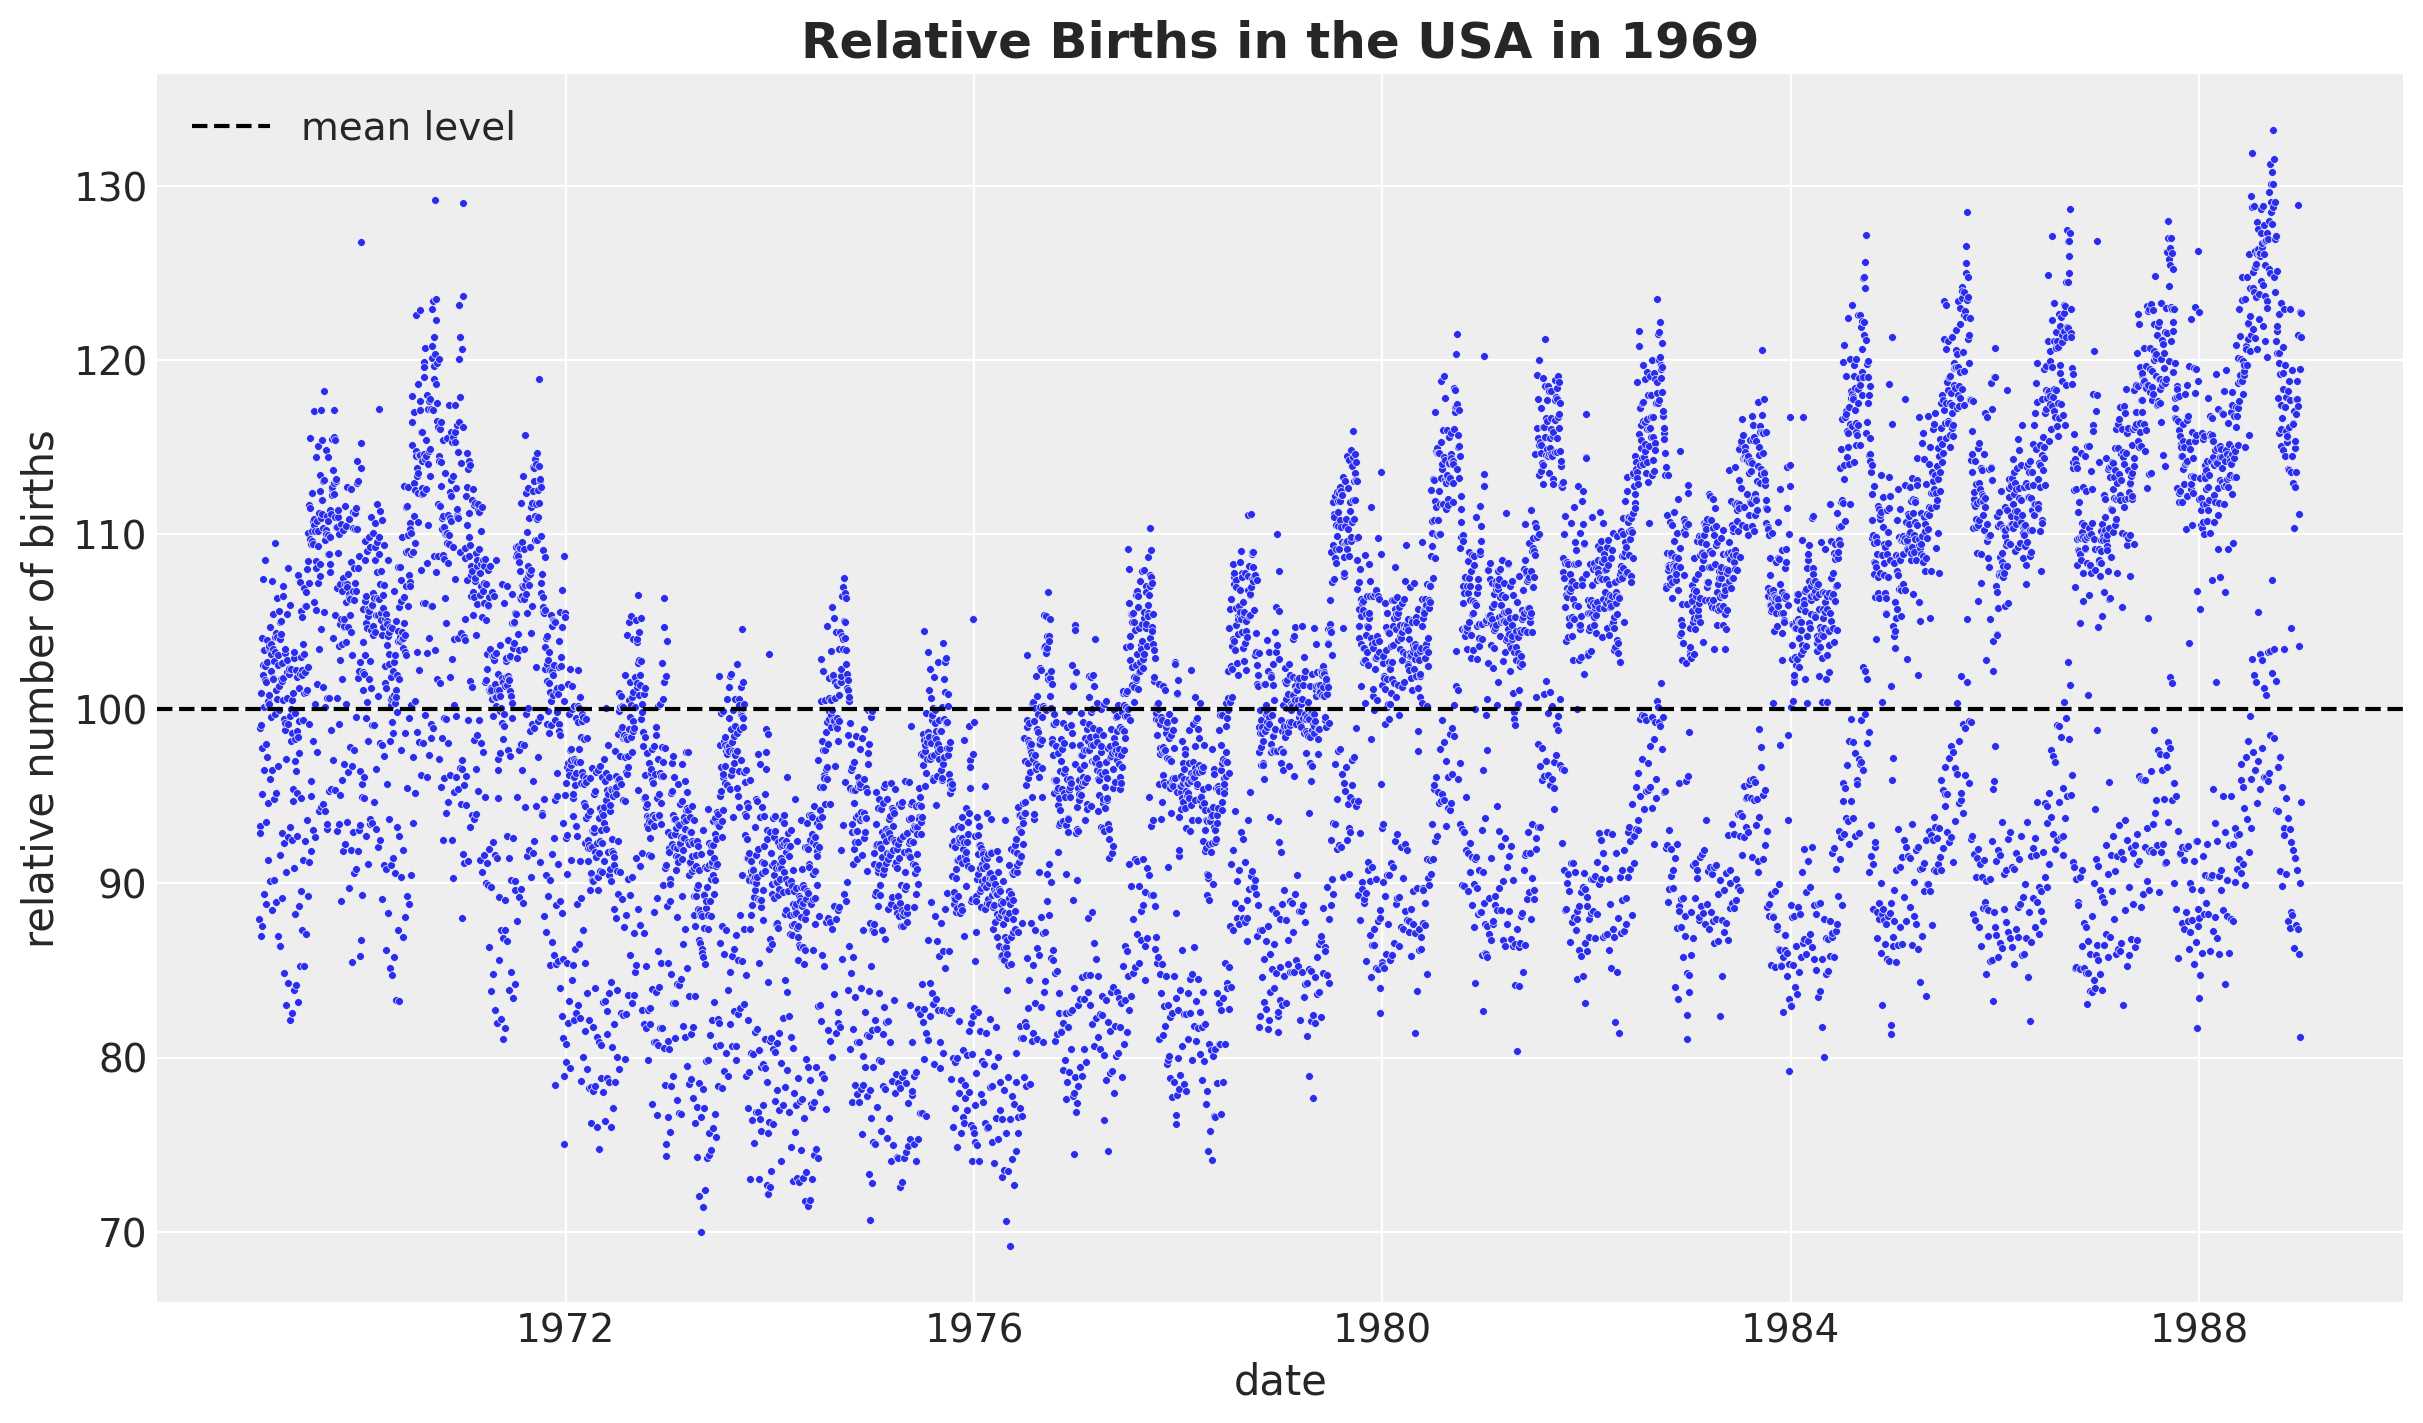

In [6]:
fig, ax = plt.subplots()
sns.scatterplot(data=data_df, x="date", y="births_relative100", c="C0", s=8, ax=ax)
ax.axhline(100, color="black", linestyle="--", label="mean level")
ax.legend()
ax.set(xlabel="date", ylabel="relative number of births")
ax.set_title(label="Relative Births in the USA in 1969", fontsize=18, fontweight="bold")

[Text(0.5, 0, 'day of year'),
 Text(0, 0.5, 'relative number of births per day of year')]

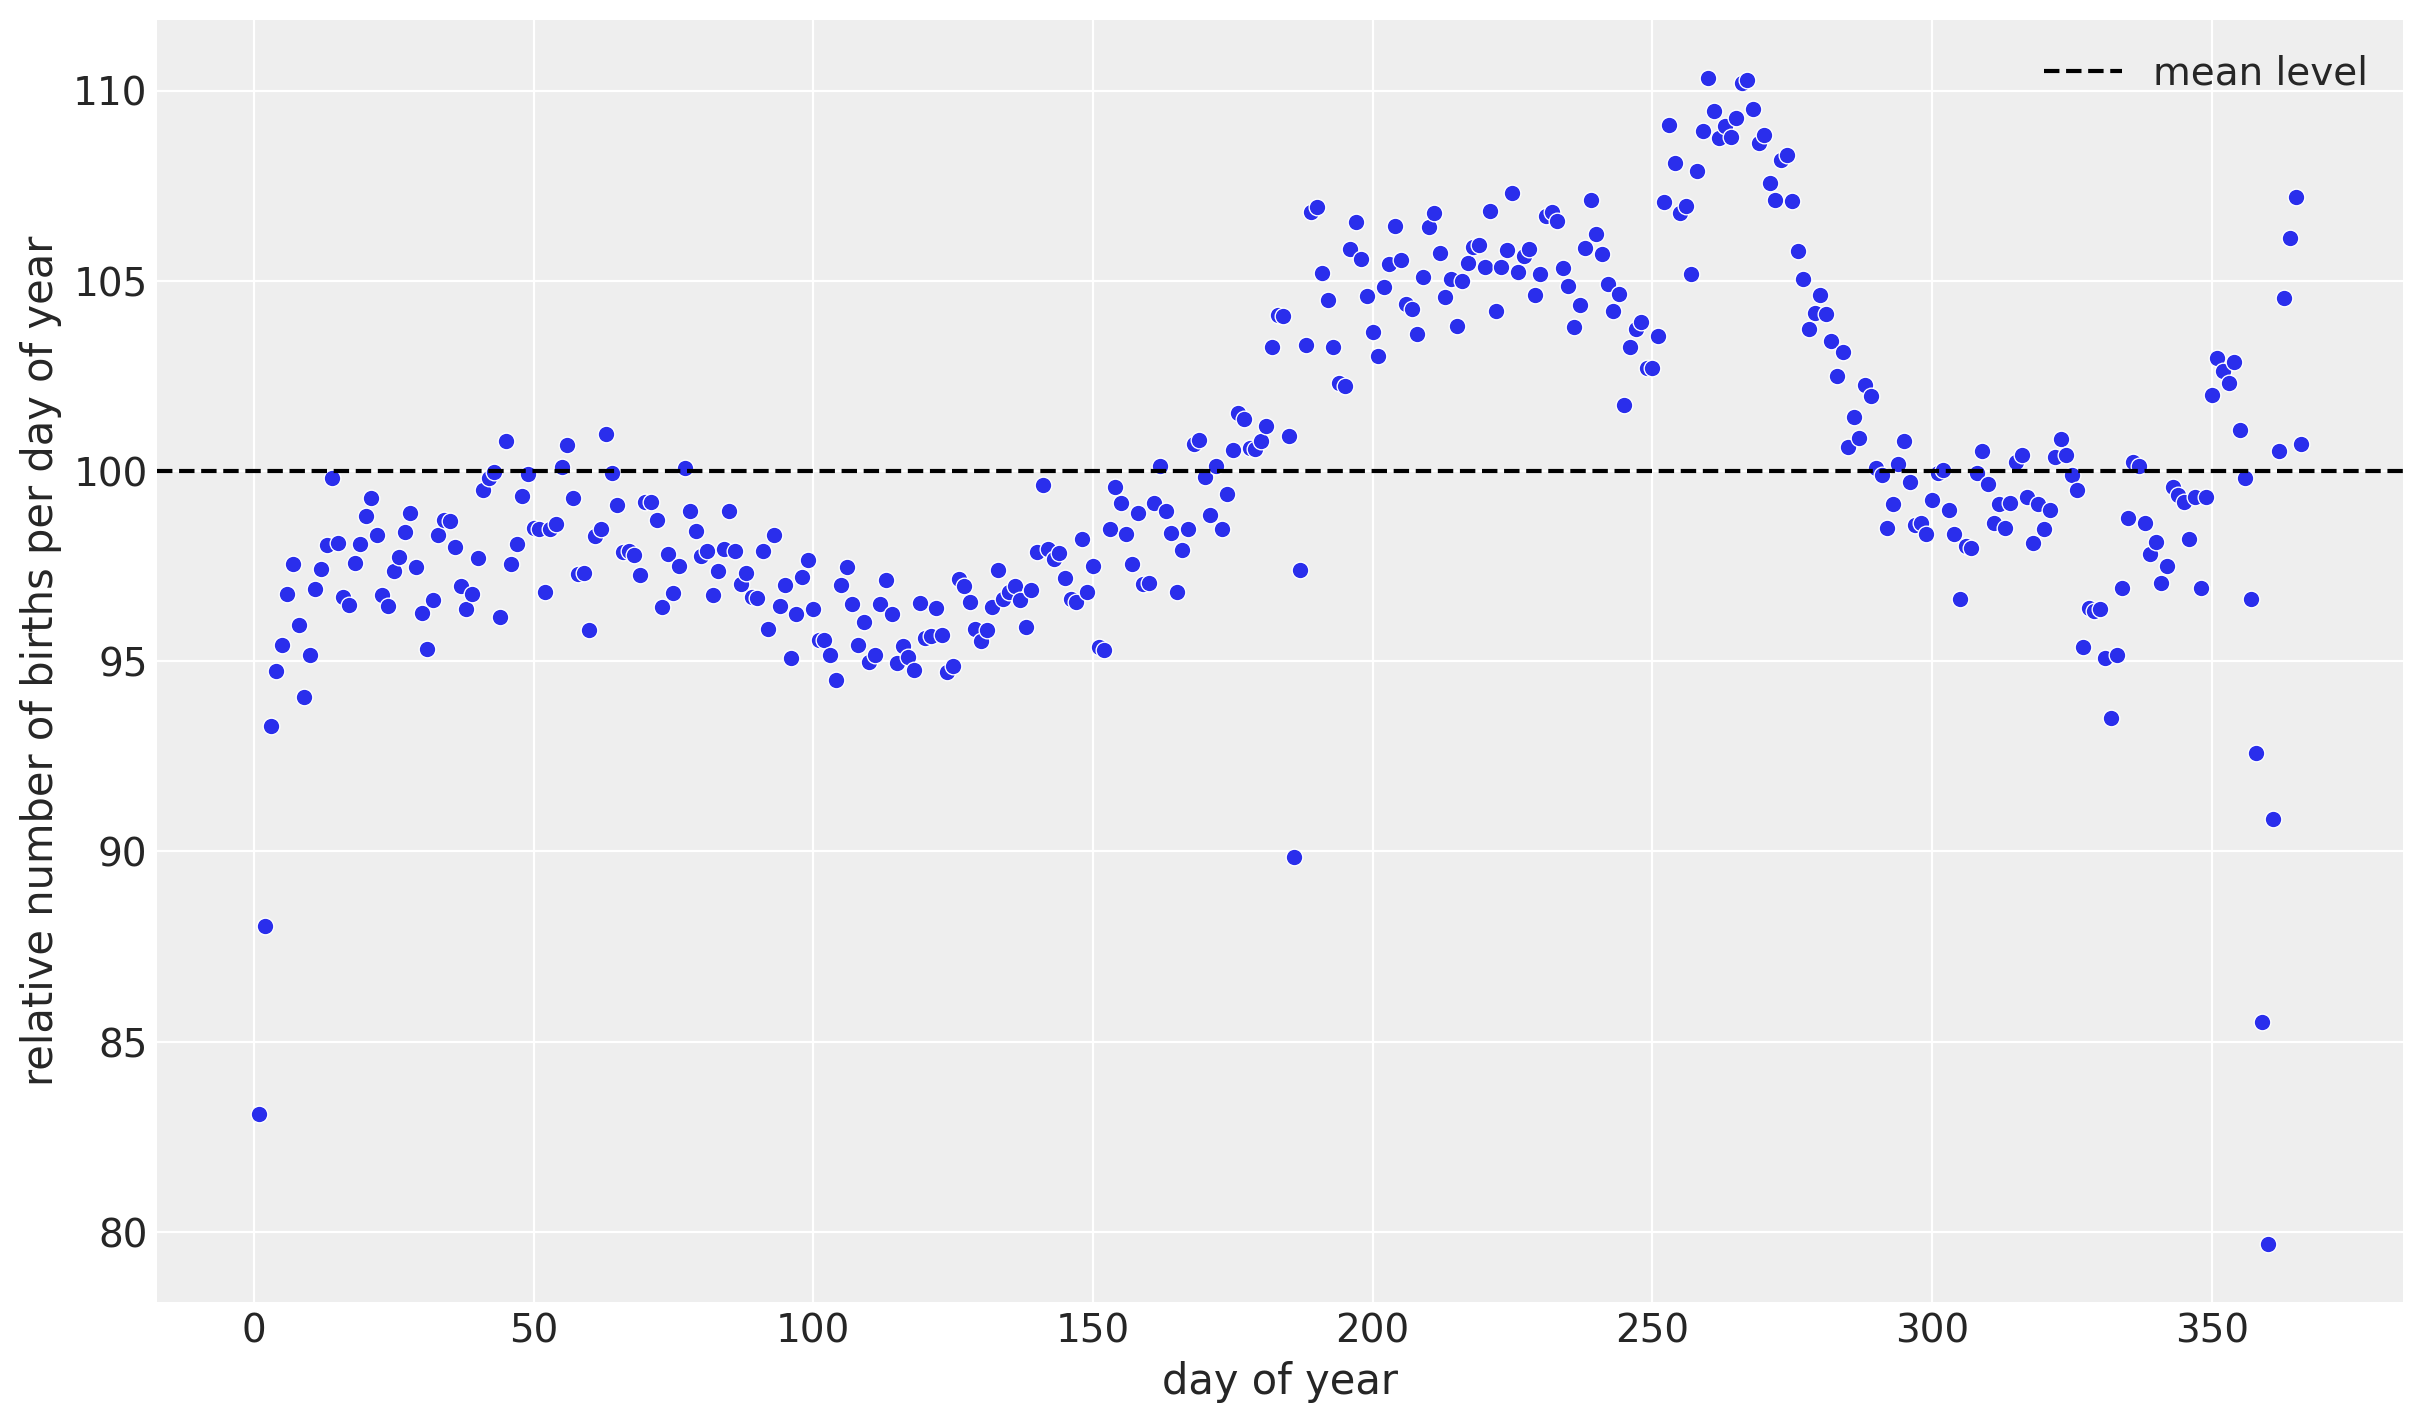

In [7]:
fig, ax = plt.subplots()
(
    data_df.groupby(["day_of_year2"], as_index=False)
    .agg(meanbirths=("births_relative100", "mean"))
    .pipe((sns.scatterplot, "data"), x="day_of_year2", y="meanbirths", c="C0", ax=ax)
)
ax.axhline(100, color="black", linestyle="--", label="mean level")
ax.legend()
ax.set(xlabel="day of year", ylabel="relative number of births per day of year")

[Text(0.5, 0, 'day of week'),
 Text(0, 0.5, 'relative number of births per day of week')]

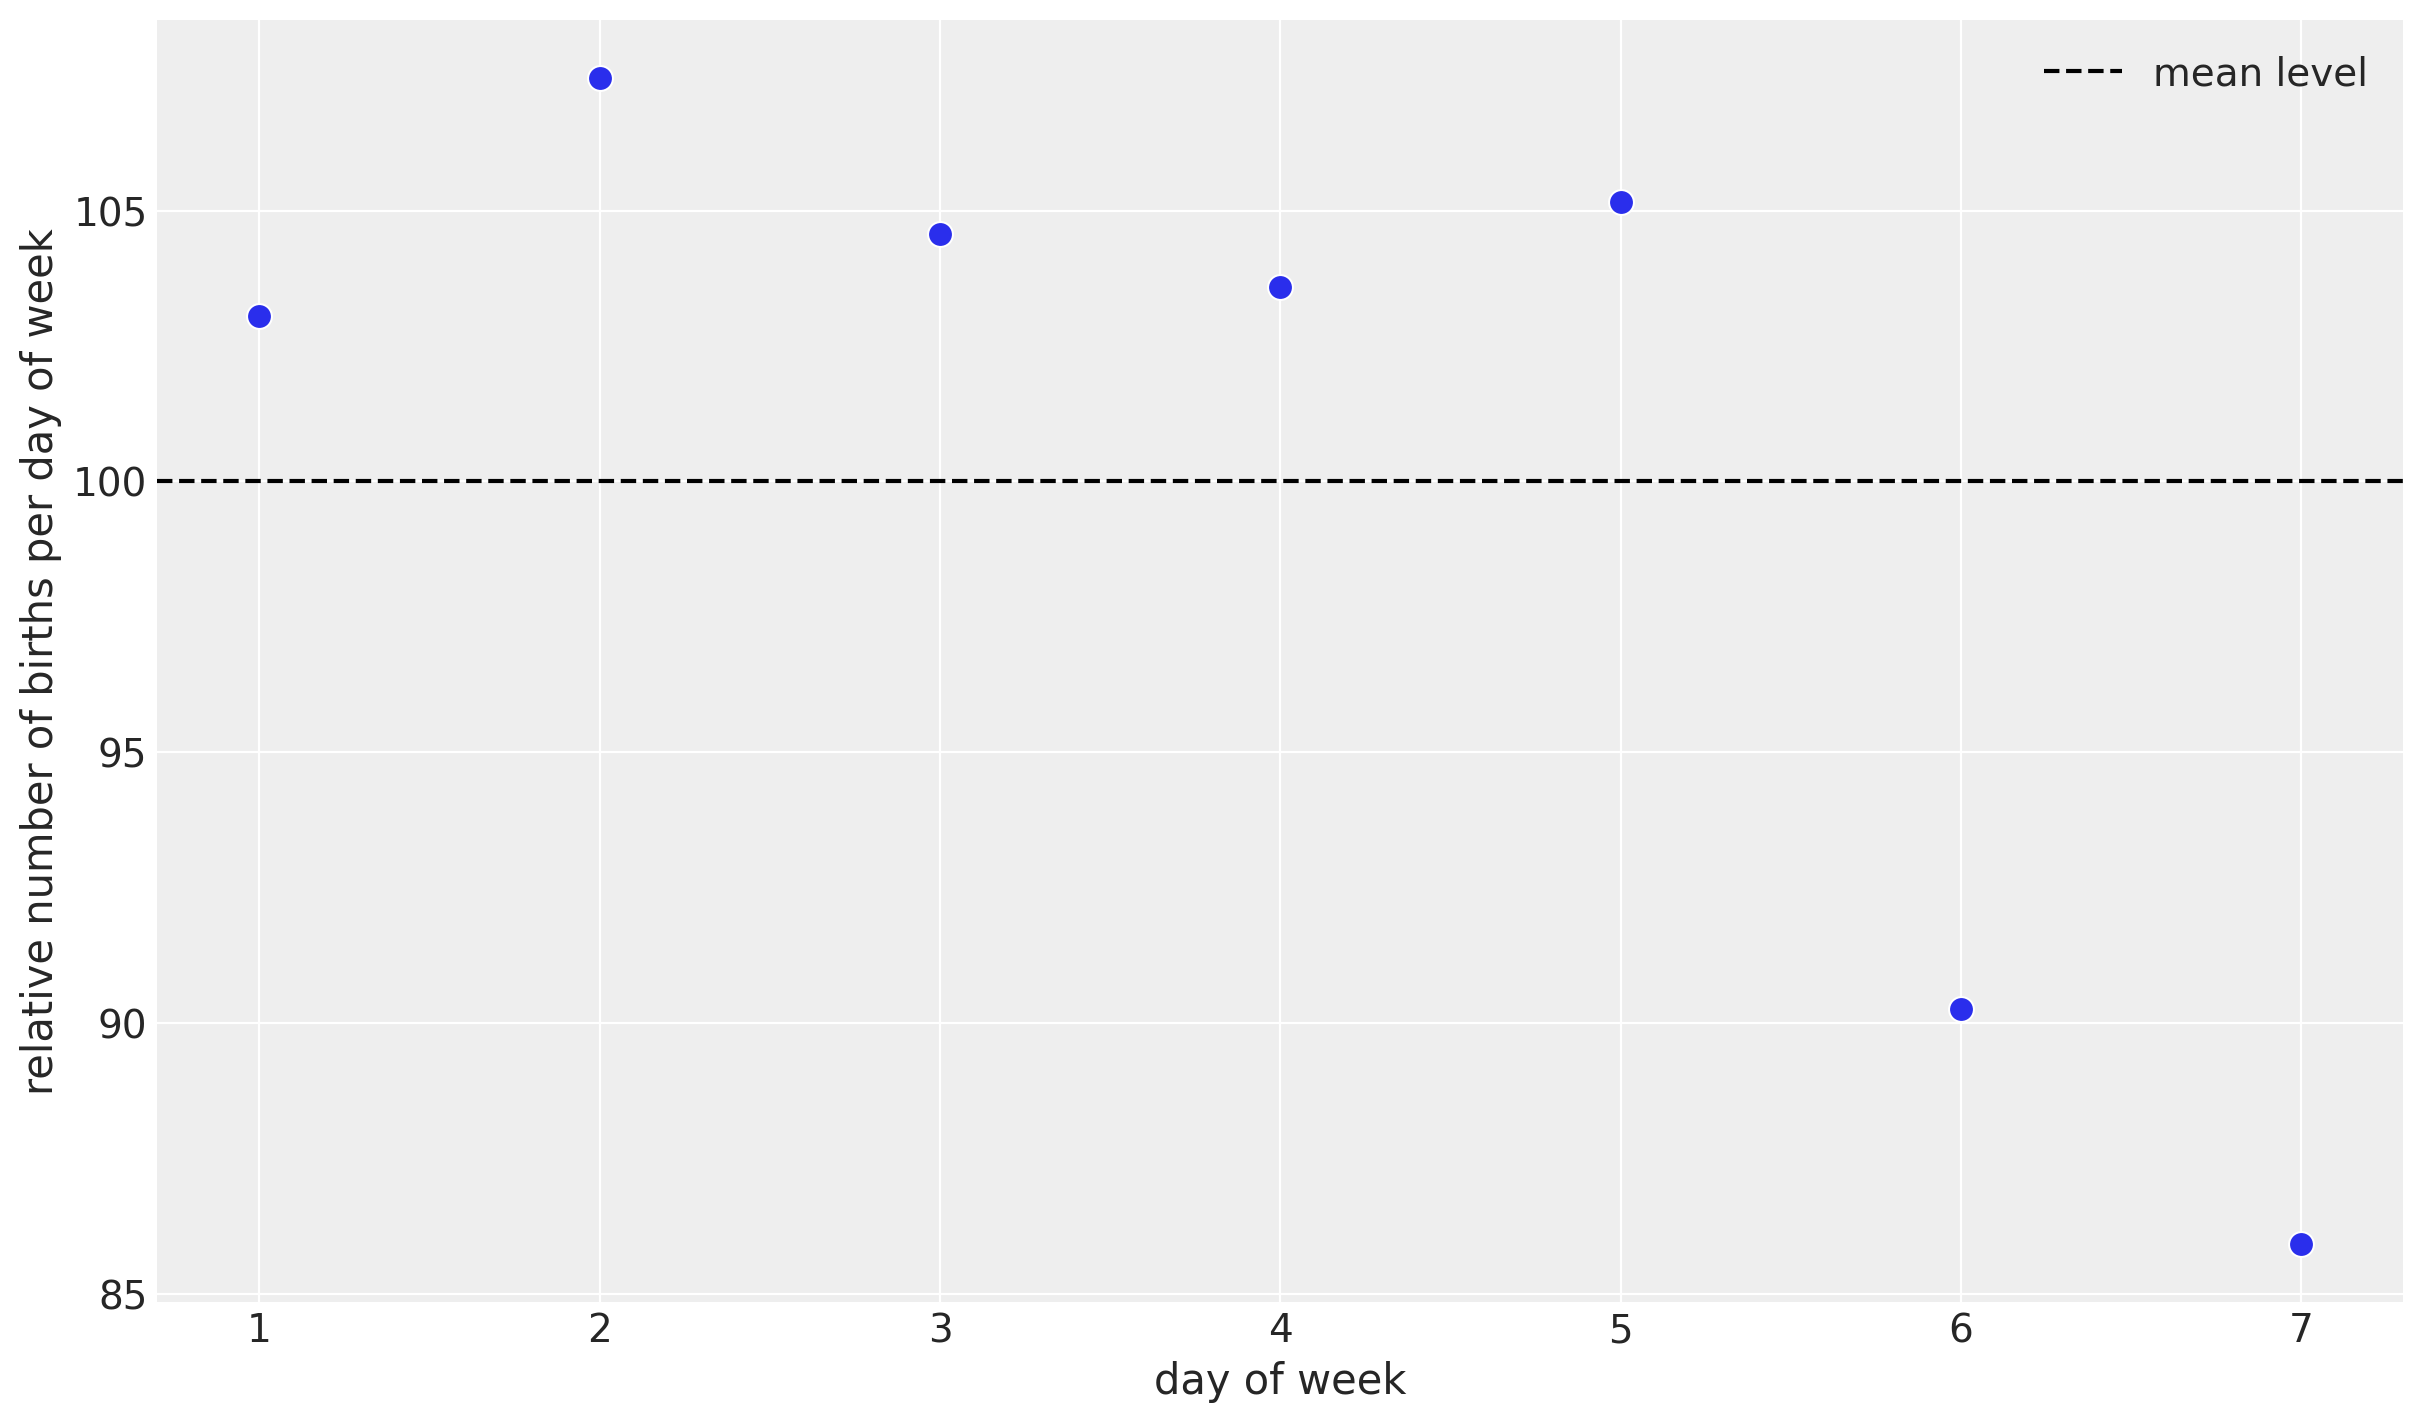

In [8]:
fig, ax = plt.subplots()
(
    data_df.groupby(["day_of_week"], as_index=False)
    .agg(meanbirths=("births_relative100", "mean"))
    .pipe(
        (sns.scatterplot, "data"), x="day_of_week", y="meanbirths", c="C0", s=80, ax=ax
    )
)
ax.axhline(100, color="black", linestyle="--", label="mean level")
ax.legend()
ax.set(xlabel="day of week", ylabel="relative number of births per day of week")

In [9]:
n = data_df.shape[0]
obs = data_df["obs"].to_numpy()
date = data_df["date"].to_numpy()
year = data_df["year"].to_numpy()
day_of_week_idx, day_of_week = data_df["day_of_week"].factorize(sort=True)
day_of_year2_idx, day_of_year2 = data_df["day_of_year2"].factorize(sort=True)
memorial_days = data_df["is_memorial_day"].to_numpy()
labor_days = data_df["is_labor_day"].to_numpy()
thanksgiving_days = data_df["is_thanksgiving_day"].to_numpy()
births_relative100 = data_df["births_relative100"].to_numpy()

In [10]:
obs_pipeline = Pipeline(steps=[("scaler", StandardScaler())])

obs_pipeline.fit(obs.reshape(-1, 1))
normalized_obs = obs_pipeline.transform(obs.reshape(-1, 1))

obs_std = obs_pipeline["scaler"].scale_.item()

births_relative100_pipeline = Pipeline(
    steps=[
        ("log", FunctionTransformer(func=np.log, inverse_func=np.exp)),
        ("scaler", StandardScaler()),
    ]
)

births_relative100_pipeline.fit(births_relative100.reshape(-1, 1))
normalized_log_births_relative100 = births_relative100_pipeline.transform(
    births_relative100.reshape(-1, 1)
)
normalized_log_births_relative100_std = births_relative100_pipeline[
    "scaler"
].scale_.item()

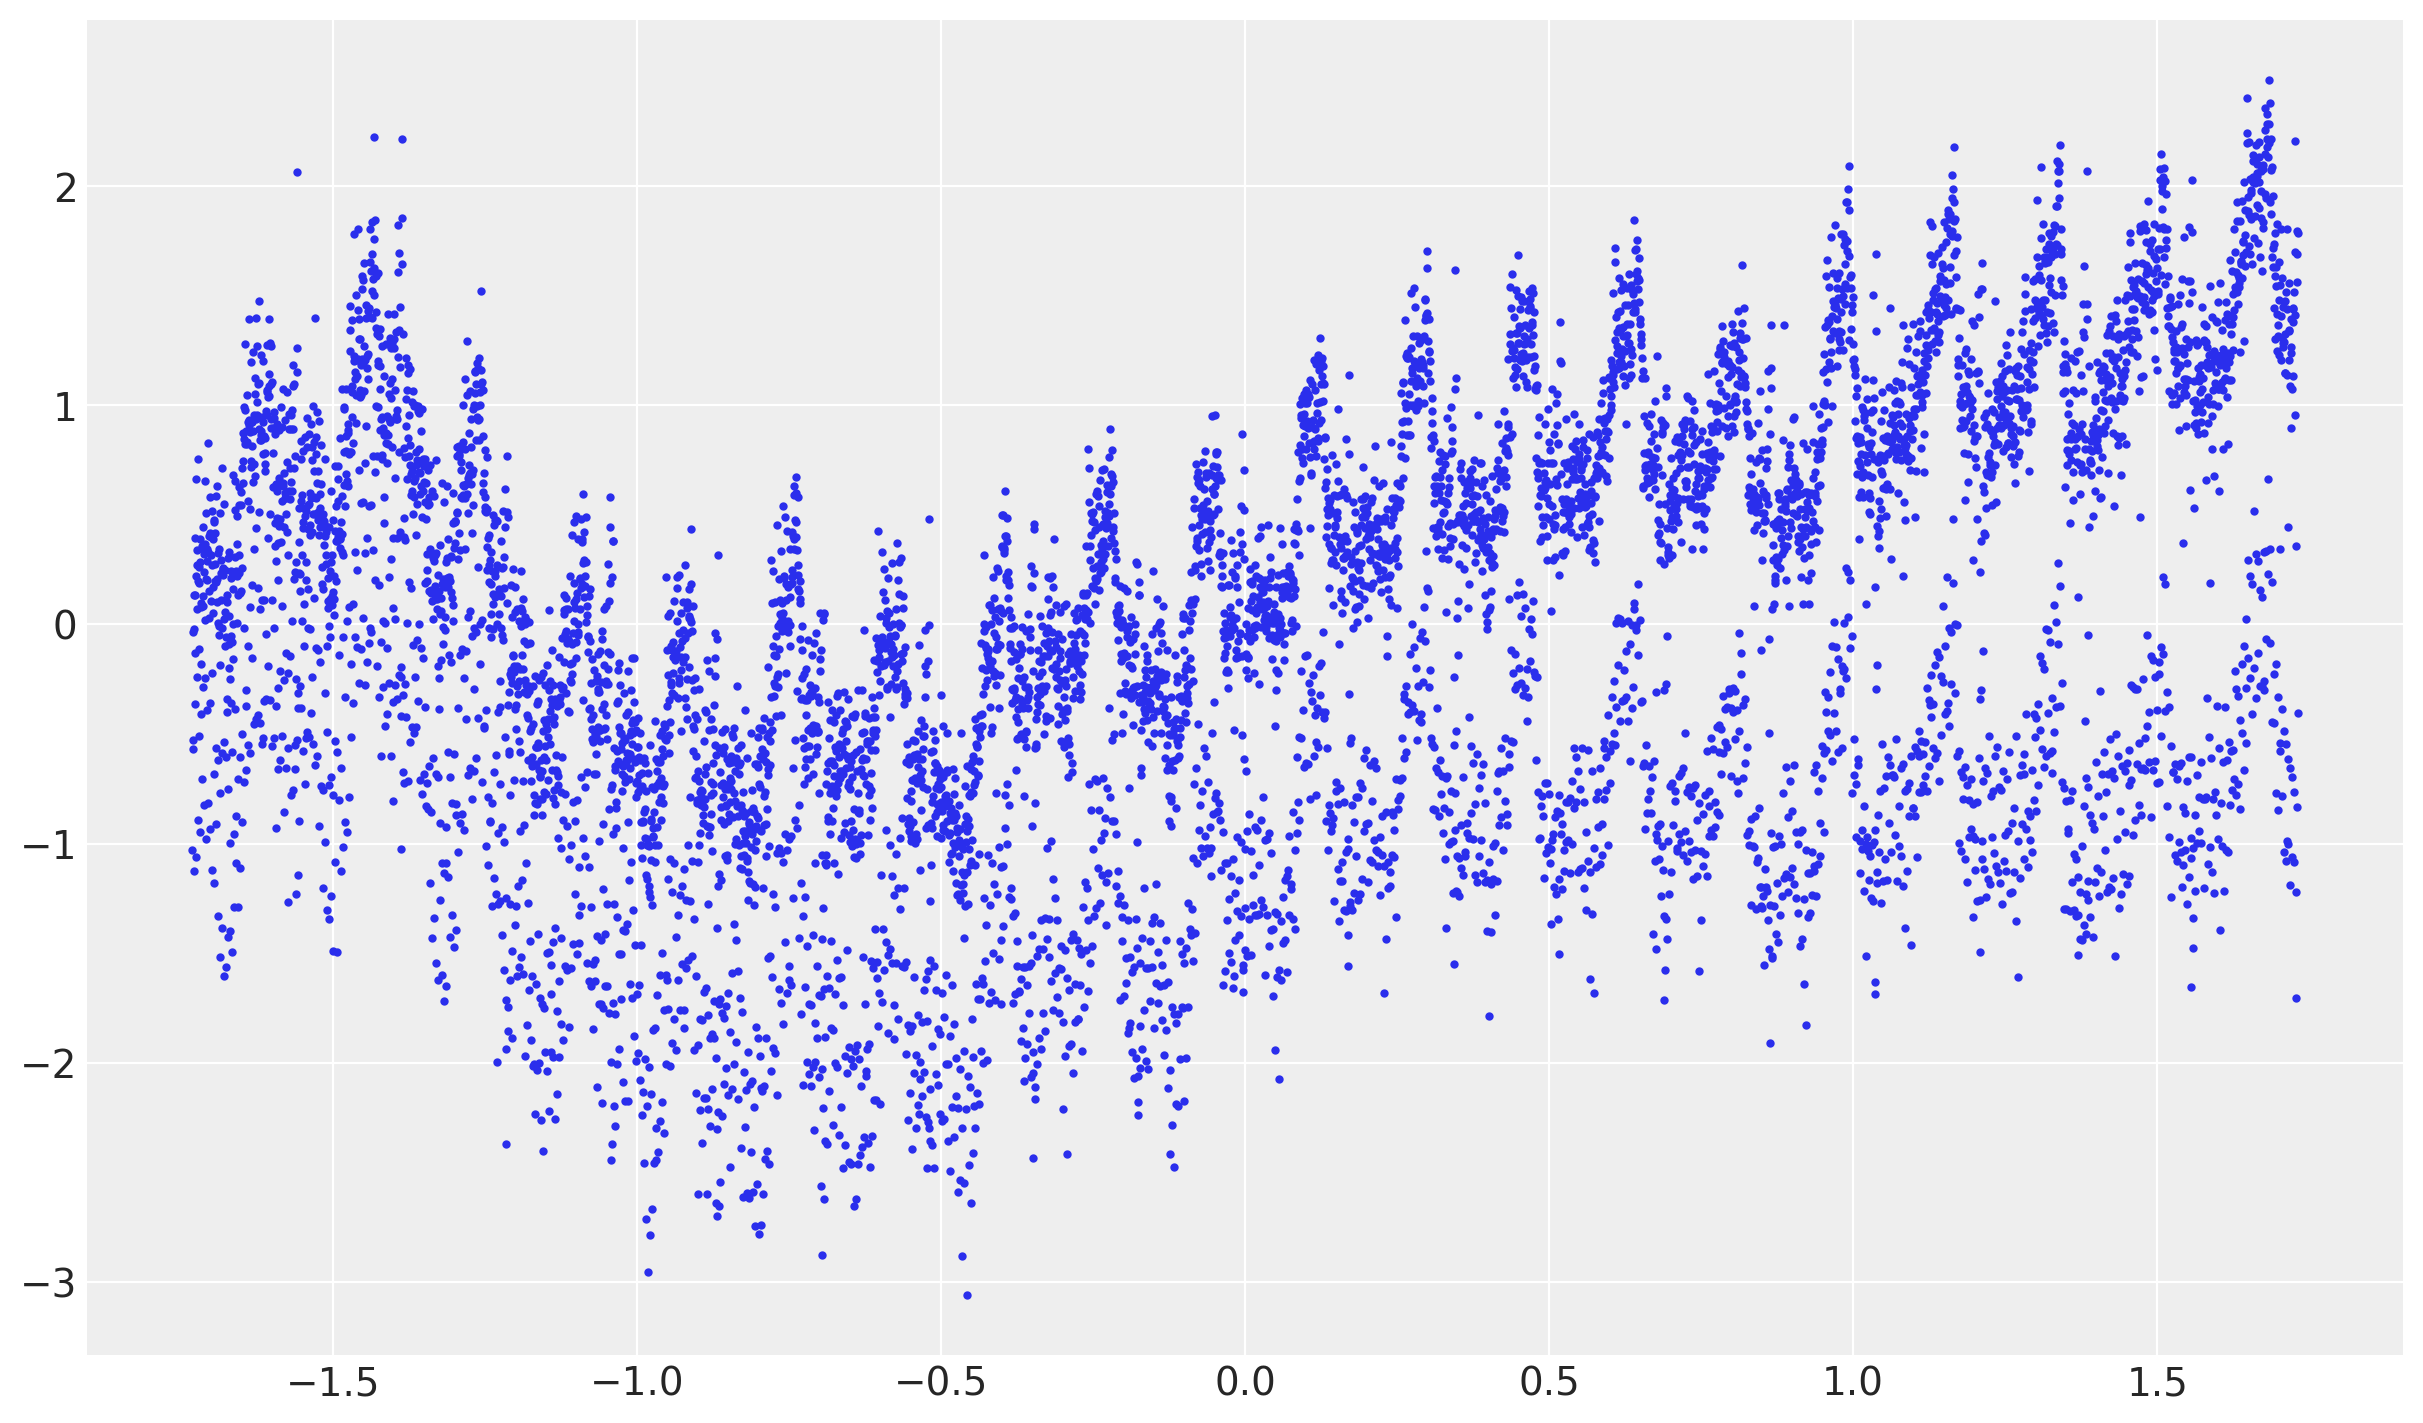

In [11]:
plt.plot(normalized_obs, normalized_log_births_relative100, "o", c="C0", markersize=2)

In [12]:
obs_std = obs.std()
normalized_obs = (obs - obs.mean()) / obs.std()


log_births_relative100 = np.log(births_relative100)
normalized_log_births_relative100 = (
    log_births_relative100 - log_births_relative100.mean()
) / log_births_relative100.std()

<Axes: >

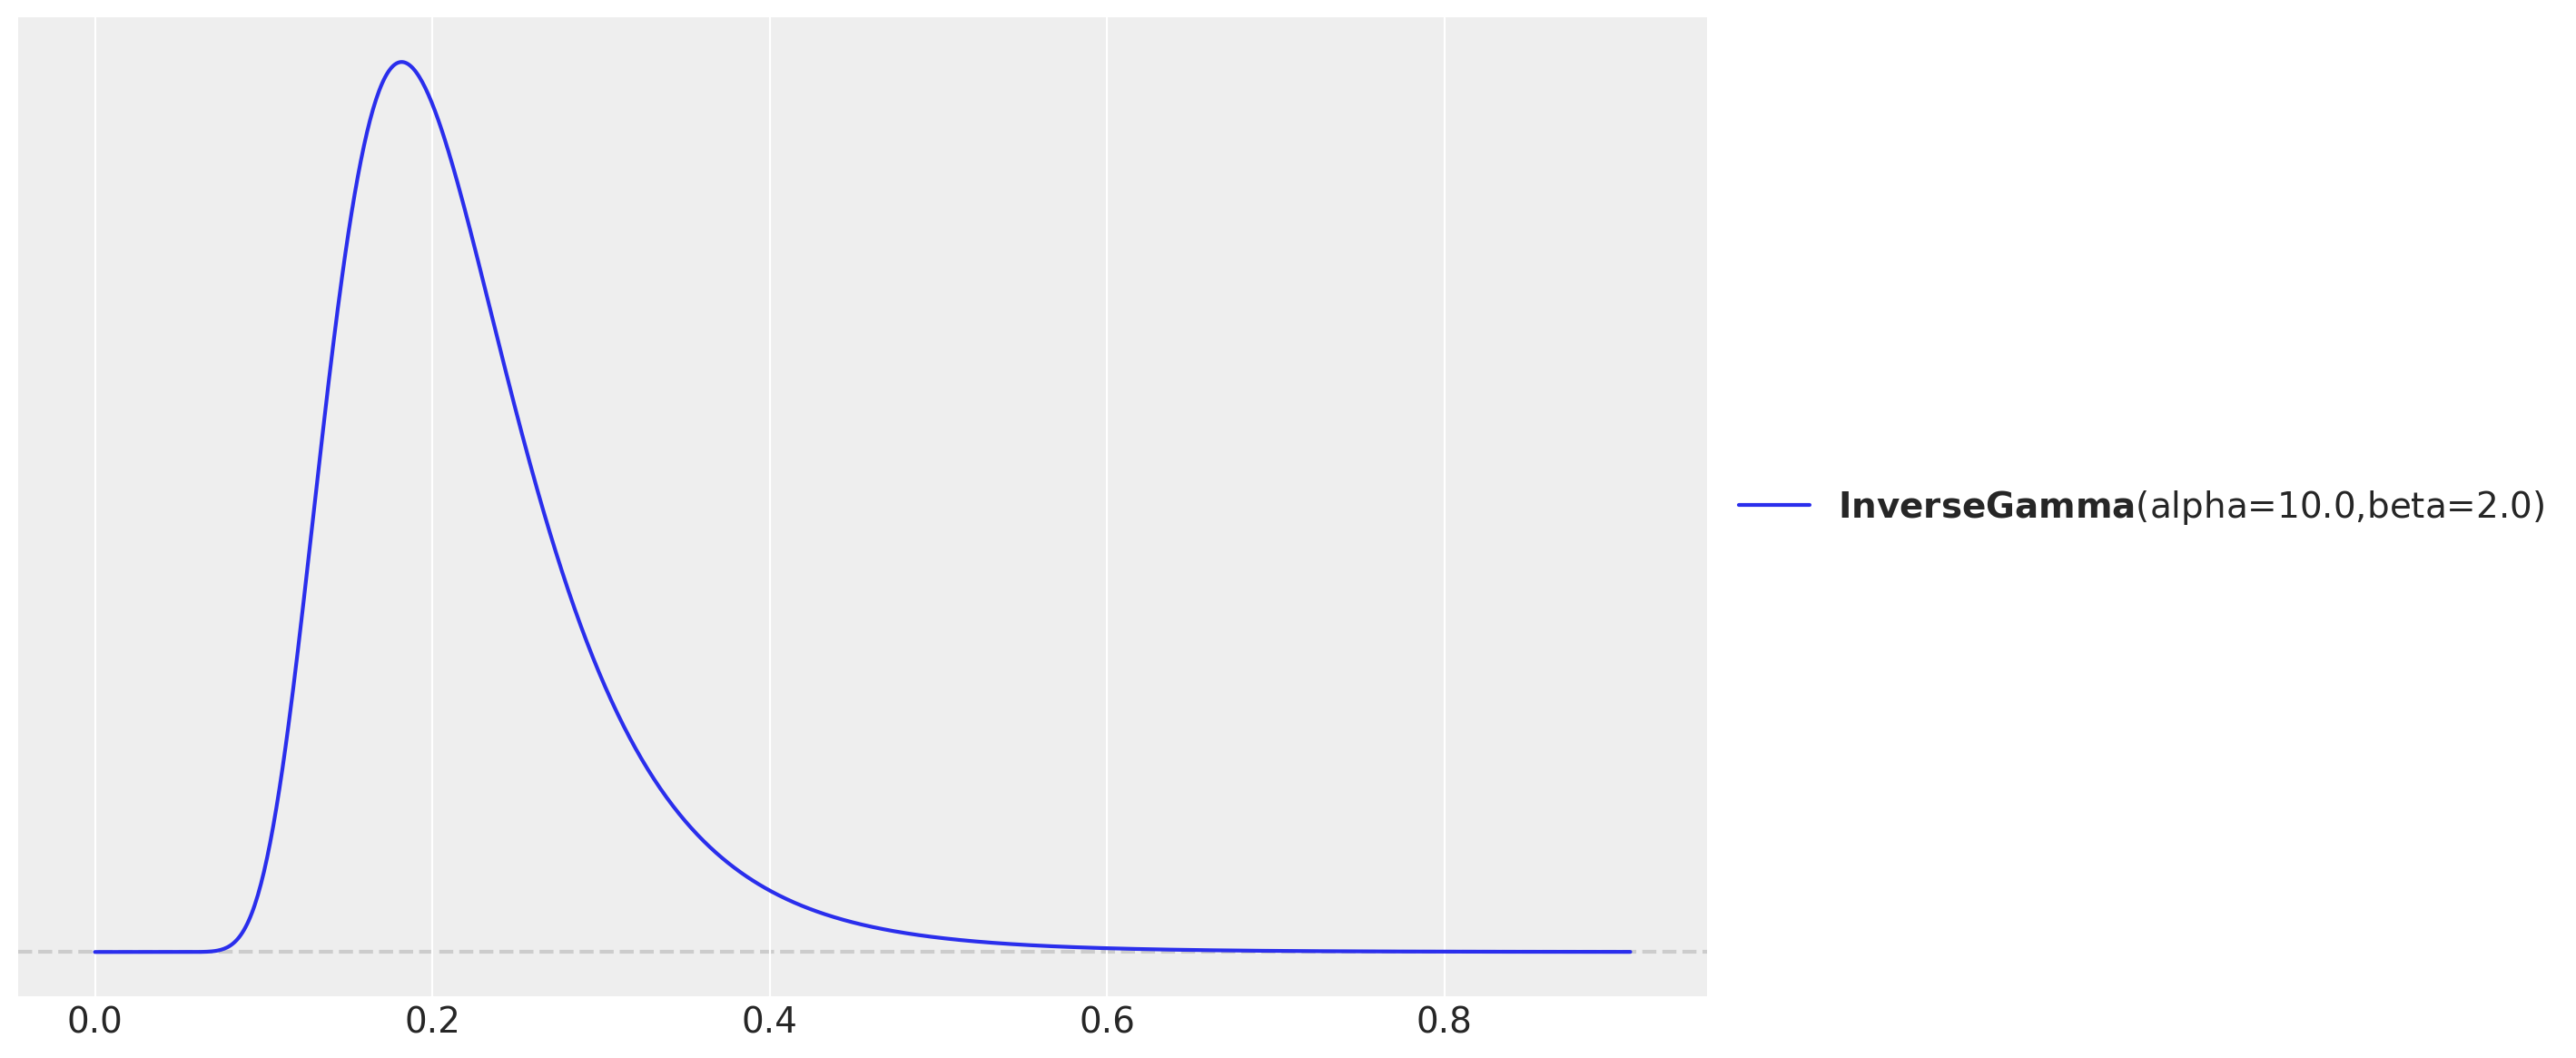

In [13]:
pz.InverseGamma(alpha=10, beta=2).plot_pdf()

<Axes: >

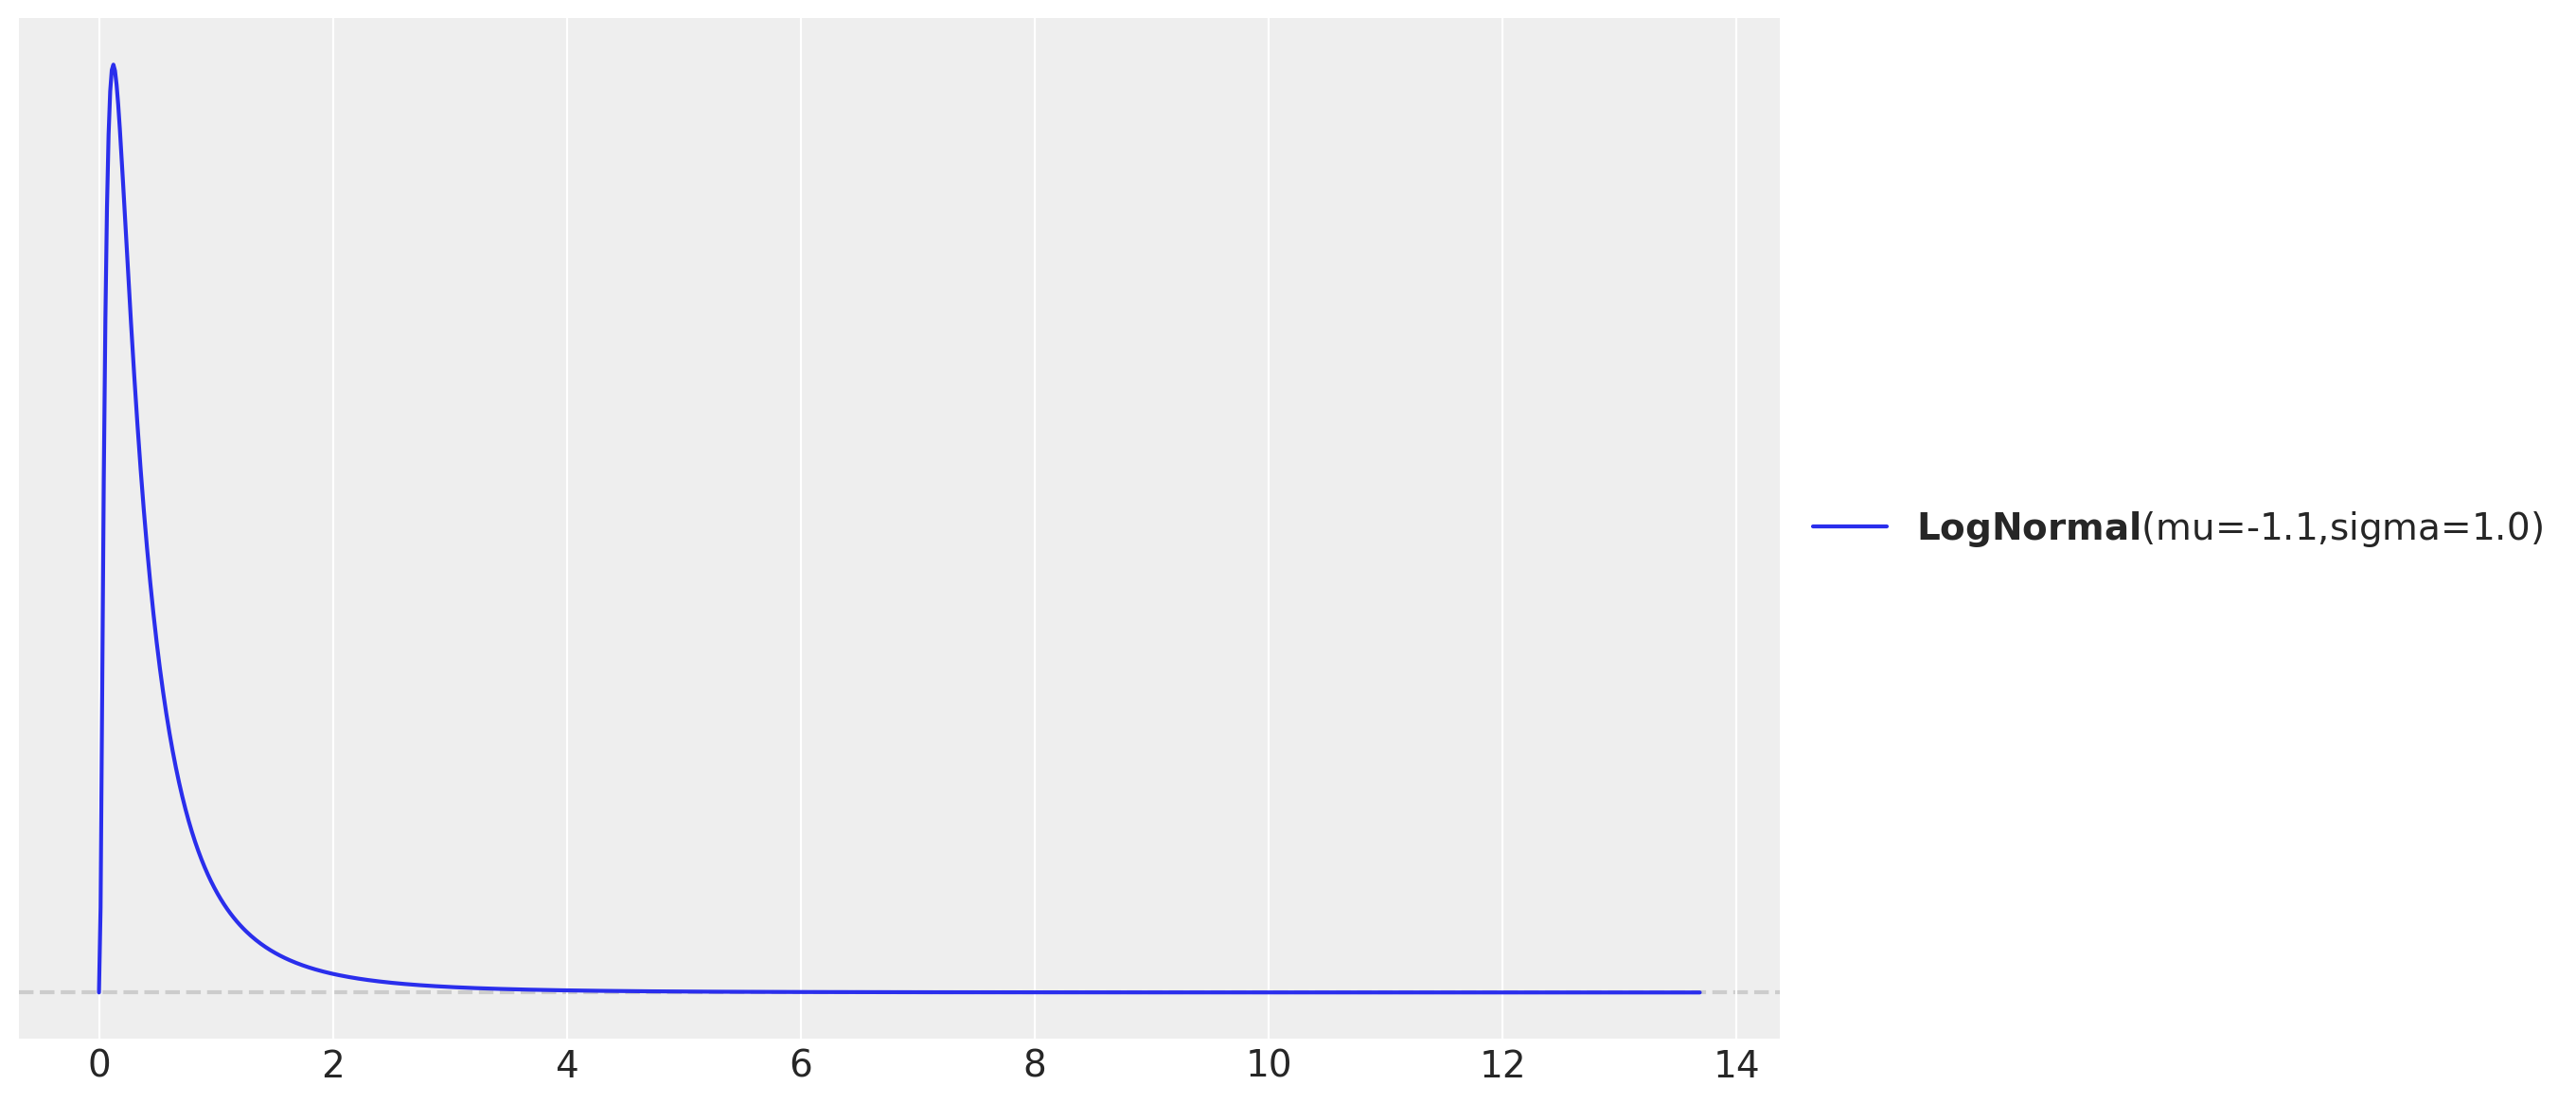

In [14]:
pz.LogNormal(mu=np.log(700 / obs_std), sigma=1).plot_pdf()

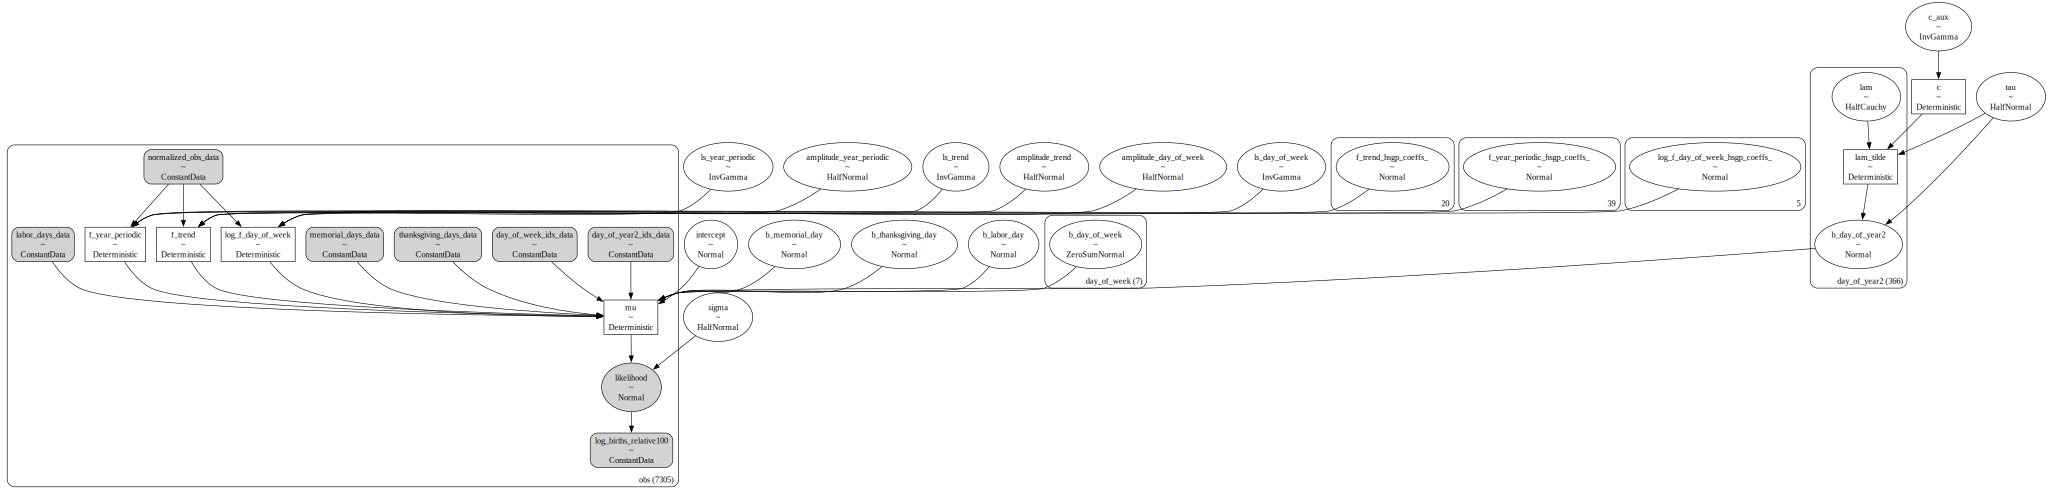

In [15]:
coords = {"obs": obs, "day_of_week": day_of_week, "day_of_year2": day_of_year2}

with pm.Model(coords=coords) as model:
    # --- Data Containers ---

    normalized_obs_data = pm.Data(
        name="normalized_obs_data", value=normalized_obs, mutable=False, dims="obs"
    )

    day_of_week_idx_data = pm.Data(
        name="day_of_week_idx_data", value=day_of_week_idx, mutable=False, dims="obs"
    )

    day_of_year2_idx_data = pm.Data(
        name="day_of_year2_idx_data", value=day_of_year2_idx, mutable=False, dims="obs"
    )

    memorial_days_data = pm.Data(
        name="memorial_days_data", value=memorial_days, mutable=False, dims="obs"
    )

    labor_days_data = pm.Data(
        name="labor_days_data", value=labor_days, mutable=False, dims="obs"
    )

    thanksgiving_days_data = pm.Data(
        name="thanksgiving_days_data",
        value=thanksgiving_days,
        mutable=False,
        dims="obs",
    )

    normalized_log_births_relative100_data = pm.Data(
        name="log_births_relative100",
        value=normalized_log_births_relative100,
        mutable=False,
        dims="obs",
    )

    # --- Priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)

    amplitude_trend = pm.HalfNormal(name="amplitude_trend", sigma=1.0)
    ls_trend = pm.InverseGamma(name="ls_trend", alpha=10, beta=2)
    cov_trend = amplitude_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_trend)
    gp_trend = pm.gp.HSGP(m=[20], c=1.5, cov_func=cov_trend)
    f_trend = gp_trend.prior(name="f_trend", X=normalized_obs_data[:, None], dims="obs")

    amplitude_year_periodic = pm.HalfNormal(name="amplitude_year_periodic", sigma=1)
    ls_year_periodic = pm.InverseGamma(name="ls_year_periodic", alpha=10, beta=2)
    gp_year_periodic = pm.gp.HSGPPeriodic(
        m=20,
        scale=amplitude_year_periodic,
        cov_func=pm.gp.cov.Periodic(
            input_dim=1, period=365.25 / obs_std, ls=ls_year_periodic
        ),
    )
    f_year_periodic = gp_year_periodic.prior(
        name="f_year_periodic", X=normalized_obs_data[:, None], dims="obs"
    )

    amplitude_day_of_week = pm.HalfNormal(name="amplitude_day_of_week", sigma=1)
    ls_day_of_week = pm.InverseGamma(name="ls_day_of_week", alpha=10, beta=2)
    cov_day_of_week = amplitude_day_of_week * pm.gp.cov.ExpQuad(
        input_dim=1, ls=ls_day_of_week
    )
    gp_day_of_week = pm.gp.HSGP(m=[5], c=1.5, cov_func=cov_day_of_week)
    log_f_day_of_week = gp_day_of_week.prior(
        name="log_f_day_of_week", X=normalized_obs_data[:, None], dims="obs"
    )

    b_day_of_week = pm.ZeroSumNormal(name="b_day_of_week", sigma=1, dims="day_of_week")

    slab_df = 50
    slab_scale = 2
    scale_global = 0.1
    tau = pm.HalfNormal(name="tau", sigma=2 * scale_global)
    c_aux = pm.InverseGamma(name="c_aux", alpha=slab_df / 2, beta=slab_df / 2)
    c = pm.Deterministic(name="c", var=slab_scale * pt.sqrt(c_aux))
    lam = pm.HalfCauchy(name="lam", beta=1, dims="day_of_year2")

    lam_tilde = pm.Deterministic(
        name="lam_tilde",
        var=pt.sqrt(c) * lam / pt.sqrt(c + (tau * lam) ** 2),
        dims="day_of_year2",
    )

    b_day_of_year2 = pm.Normal(
        name="b_day_of_year2", mu=0, sigma=tau * lam_tilde, dims="day_of_year2"
    )

    b_memorial_day = pm.Normal(name="b_memorial_day", mu=0, sigma=1)
    b_labor_day = pm.Normal(name="b_labor_day", mu=0, sigma=1)
    b_thanksgiving_day = pm.Normal(name="b_thanksgiving_day", mu=0, sigma=1)

    sigma = pm.HalfNormal(name="sigma", sigma=0.5)

    # --- Parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=intercept
        + f_trend
        + f_year_periodic
        + pt.exp(log_f_day_of_week) * b_day_of_week[day_of_week_idx_data]
        + b_day_of_year2[day_of_year2_idx_data]
        + b_memorial_day * memorial_days_data
        + b_labor_day * labor_days_data
        + b_thanksgiving_day * thanksgiving_days_data,
        dims="obs",
    )

    # --- Likelihood ---
    pm.Normal(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=normalized_log_births_relative100_data,
        dims="obs",
    )

pm.model_to_graphviz(model=model)

In [16]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=1_000, random_seed=rng)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Sampling: [amplitude_day_of_week, amplitude_trend, amplitude_year_periodic, b_day_of_week, b_day_of_year2, b_labor_day, b_memorial_day, b_thanksgiving_day, c_aux, f_trend_hsgp_coeffs_, f_year_periodic_hsgp_coeffs_, intercept, lam, likelihood, log_f_day_of_week_hsgp_coeffs_, ls_day_of_week, ls_trend, ls_year_periodic, sigma, tau]


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


Text(0.5, 1.0, 'Prior Predictive')

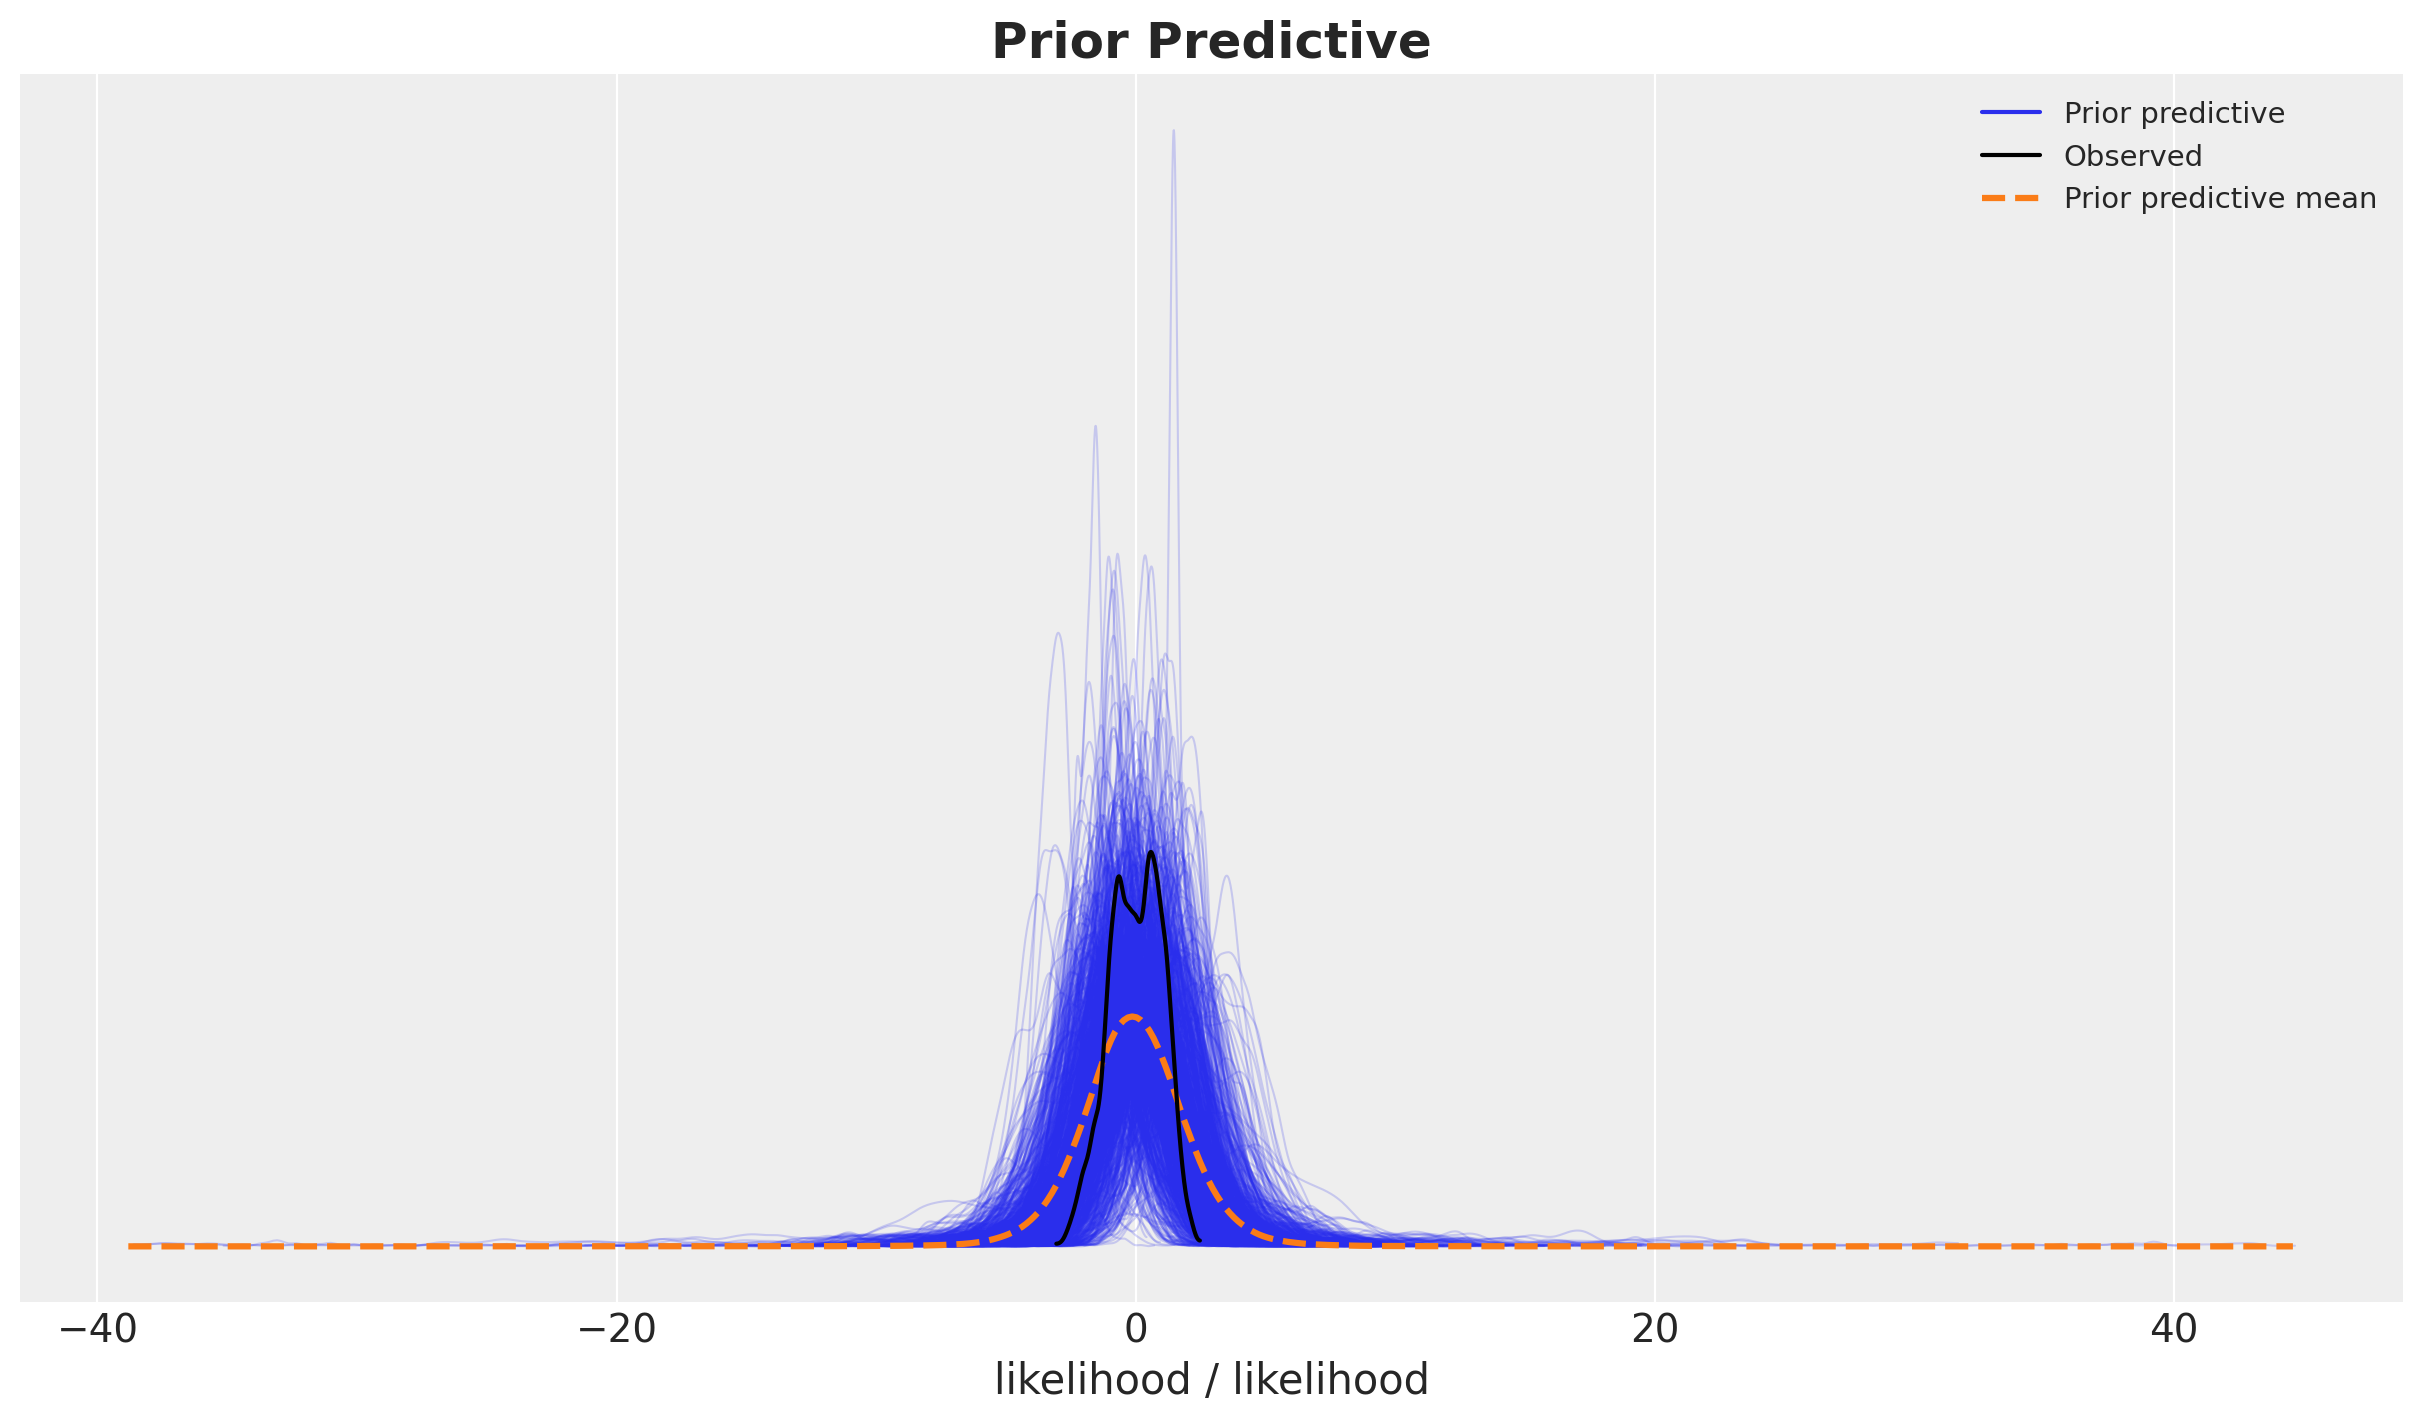

In [17]:
fig, ax = plt.subplots()
az.plot_ppc(data=prior_predictive, group="prior", kind="kde", ax=ax)
ax.set_title(label="Prior Predictive", fontsize=18, fontweight="bold")

In [18]:
with model:
    idata = pm.sample(
        tune=1_500,
        target_accept=0.95,
        draws=2_000,
        chains=4,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=rng)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Compiling...
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

Sampling time = 0:35:12.854073
Transforming variables...
Transformation time = 0:00:09.686467
Sampling: [likelihood]


In [19]:
idata["sample_stats"]["diverging"].sum().item()

191

In [20]:
var_names = [
    "intercept",
    "amplitude_trend",
    "ls_trend",
    "amplitude_year_periodic",
    "ls_year_periodic",
    "b_day_of_week",
    "b_memorial_day",
    "b_labor_day",
    "b_thanksgiving_day",
    "sigma",
]

az.summary(data=idata, var_names=var_names, round_to=3)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept                0.052  0.208  -0.325    0.469      0.032    0.023   
amplitude_trend          0.459  0.193   0.153    0.802      0.027    0.019   
ls_trend                 0.210  0.027   0.161    0.259      0.004    0.003   
amplitude_year_periodic  1.023  0.138   0.805    1.295      0.040    0.029   
ls_year_periodic         0.150  0.009   0.133    0.167      0.001    0.001   
b_day_of_week[1]         0.289  0.025   0.250    0.344      0.006    0.005   
b_day_of_week[2]         0.606  0.051   0.518    0.709      0.012    0.009   
b_day_of_week[3]         0.377  0.032   0.322    0.442      0.008    0.006   
b_day_of_week[4]         0.328  0.028   0.281    0.387      0.007    0.005   
b_day_of_week[5]         0.450  0.038   0.383    0.526      0.009    0.007   
b_day_of_week[6]        -0.830  0.069  -0.974   -0.714      0.017    0.013   
b_day_of_week[7]        -1.219  0.102  -1.428   -1.046      0.025    0.019   
b_memorial_day          -1.229  0.054  -1.334   -1.131      0.008    0.006   
b_labor_day             -0.907  0.038  -0.975   -0.835      0.004    0.003   
b_thanksgiving_day      -1.297  0.042  -1.369   -1.212      0.010    0.007   
sigma                    0.229  0.002   0.226    0.232      0.000    0.000   

                         ess_bulk  ess_tail  r_hat  
intercept                  45.605   166.522  1.080  
amplitude_trend            49.378   141.024  1.055  
ls_trend                   44.168   142.488  1.084  
amplitude_year_periodic    12.652    33.464  1.283  
ls_year_periodic           88.917   156.870  1.073  
b_day_of_week[1]           17.194    88.384  1.170  
b_day_of_week[2]           17.424    80.905  1.172  
b_day_of_week[3]           18.067    78.070  1.164  
b_day_of_week[4]           17.057    86.628  1.173  
b_day_of_week[5]           17.447    83.034  1.171  
b_day_of_week[6]           16.960    80.733  1.177  
b_day_of_week[7]           16.502    80.037  1.181  
b_memorial_day             52.706   369.379  1.072  
b_labor_day                89.444   320.364  1.039  
b_thanksgiving_day         16.939    55.394  1.177  
sigma                     260.016   620.721  1.023

Text(0.5, 0.98, 'Rrace')

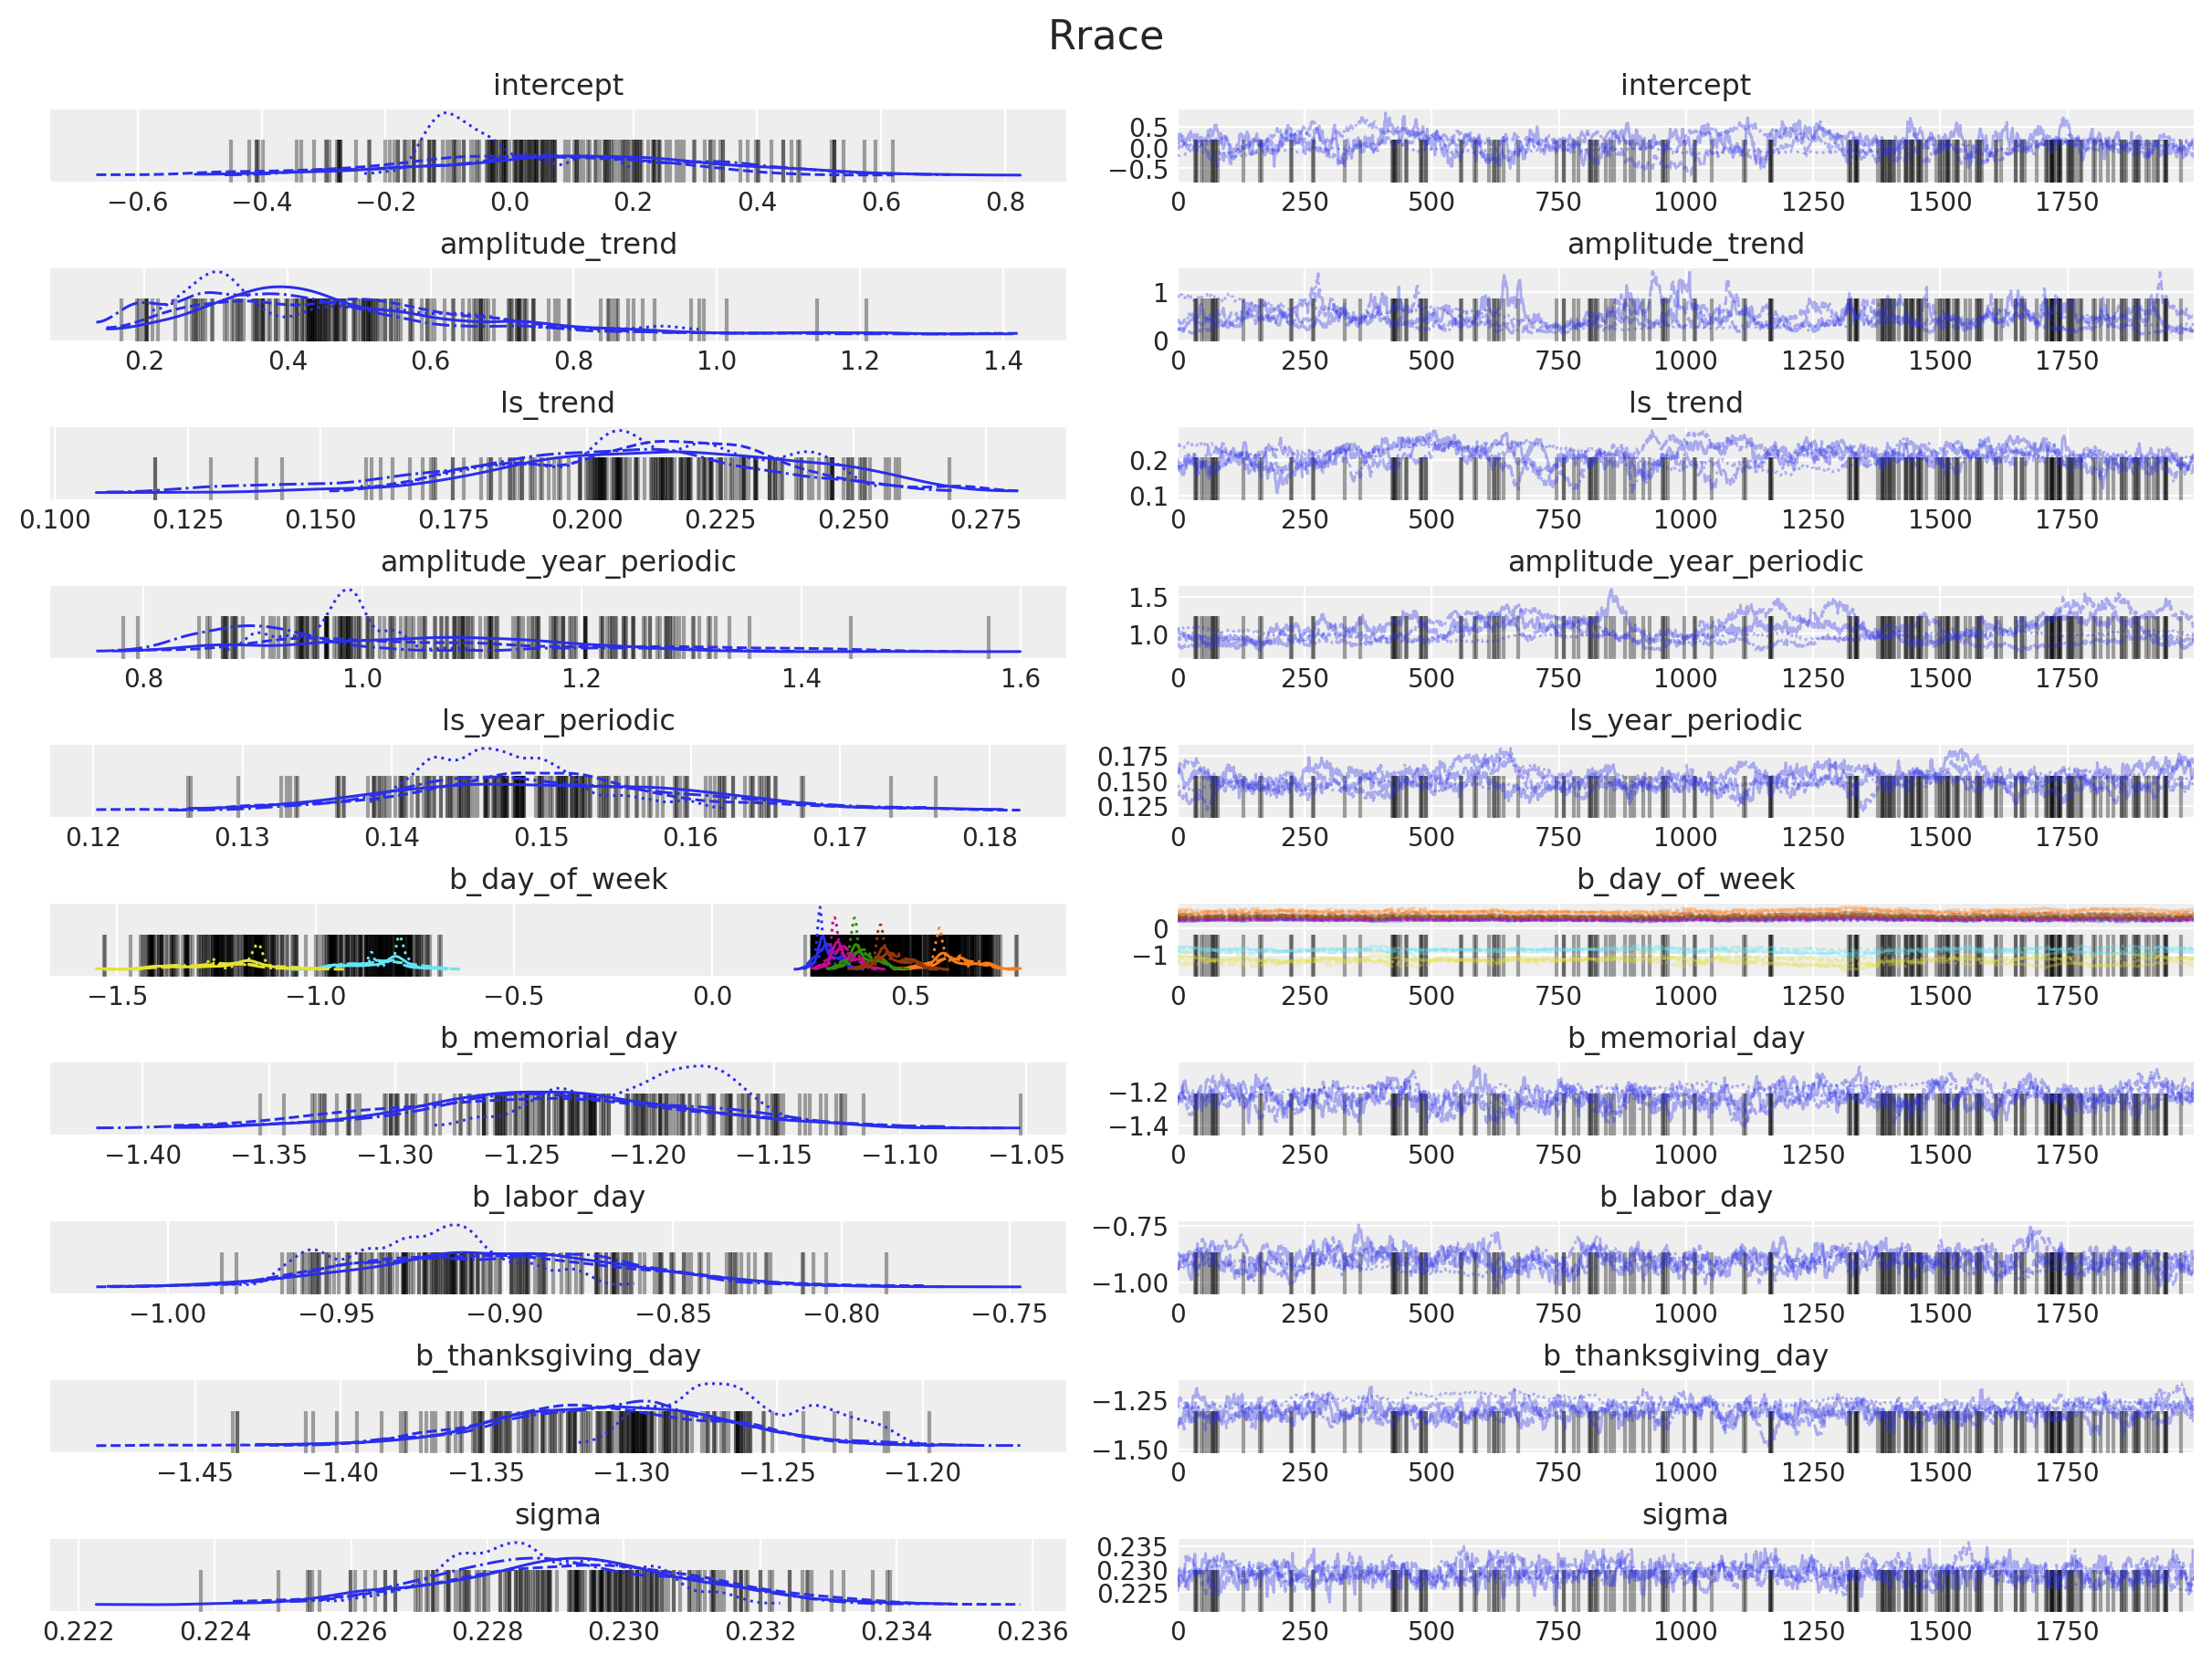

In [21]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    compact=True,
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Rrace", fontsize=16)

In [22]:
pp_mu_original_scale = xr.apply_ufunc(
    births_relative100_pipeline.inverse_transform,
    idata["posterior"]["mu"].expand_dims(dim={"_": 1}, axis=-1),
    input_core_dims=[["obs", "_"]],
    output_core_dims=[["obs", "_"]],
    vectorize=True,
).squeeze(dim="_")


pp_likelihood_original_scale = xr.apply_ufunc(
    births_relative100_pipeline.inverse_transform,
    posterior_predictive["posterior_predictive"]["likelihood"].expand_dims(
        dim={"_": 1}, axis=-1
    ),
    input_core_dims=[["obs", "_"]],
    output_core_dims=[["obs", "_"]],
    vectorize=True,
).squeeze(dim="_")

Text(0.5, 1.0, 'Relative Births in the USA in 1969\nPosterior Predictive')

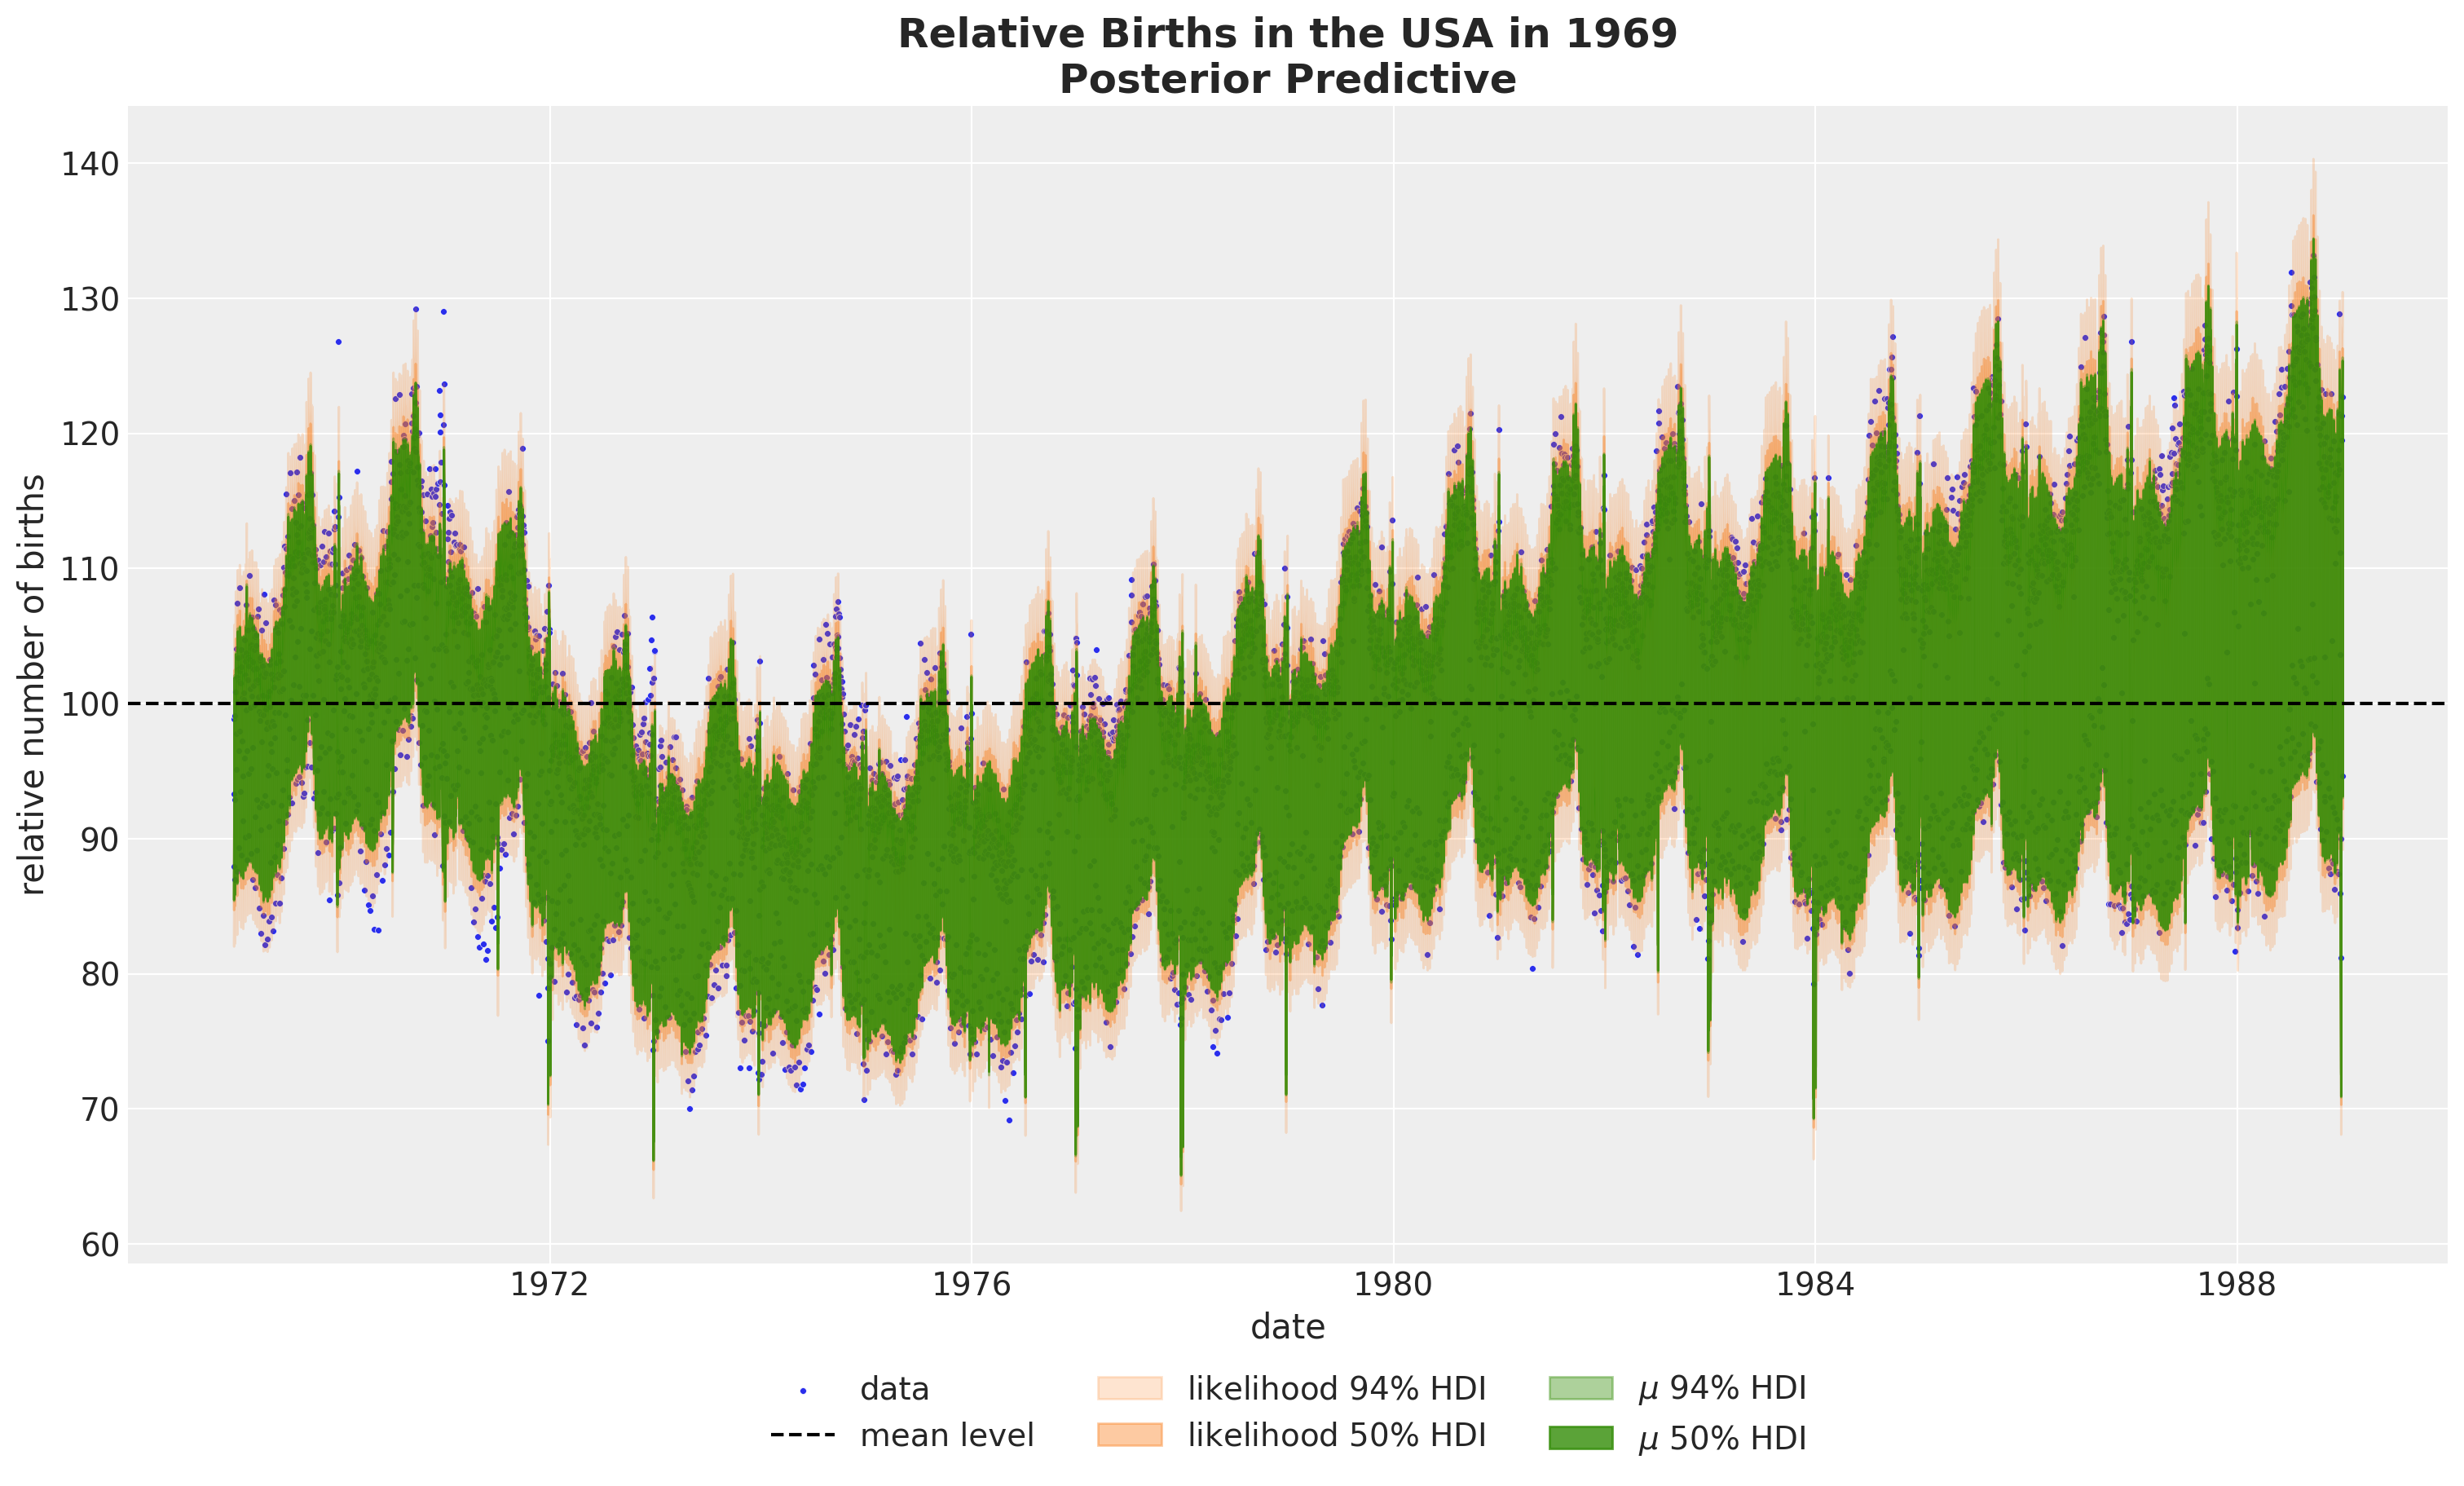

In [23]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.scatterplot(
    data=data_df, x="date", y="births_relative100", c="C0", s=8, label="data", ax=ax
)
ax.axhline(100, color="black", linestyle="--", label="mean level")
az.plot_hdi(
    x=date,
    y=pp_likelihood_original_scale,
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.2, "label": r"likelihood $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_likelihood_original_scale,
    hdi_prob=0.5,
    color="C1",
    fill_kwargs={"alpha": 0.4, "label": r"likelihood $50\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_mu_original_scale,
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.4, "label": r"$\mu$ $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_mu_original_scale,
    hdi_prob=0.9,
    color="C2",
    fill_kwargs={"alpha": 0.8, "label": r"$\mu$ $50\%$ HDI"},
    smooth=False,
    ax=ax,
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.07), ncol=3)
ax.set(xlabel="date", ylabel="relative number of births")
ax.set_title(
    label="Relative Births in the USA in 1969\nPosterior Predictive",
    fontsize=18,
    fontweight="bold",
)

In [24]:
pp_b_day_of_year2_original_scale = xr.apply_ufunc(
    births_relative100_pipeline.inverse_transform,
    idata["posterior"]["b_day_of_year2"].expand_dims(dim={"_": 1}, axis=-1),
    input_core_dims=[["day_of_year2", "_"]],
    output_core_dims=[["day_of_year2", "_"]],
    vectorize=True,
).squeeze(dim="_")

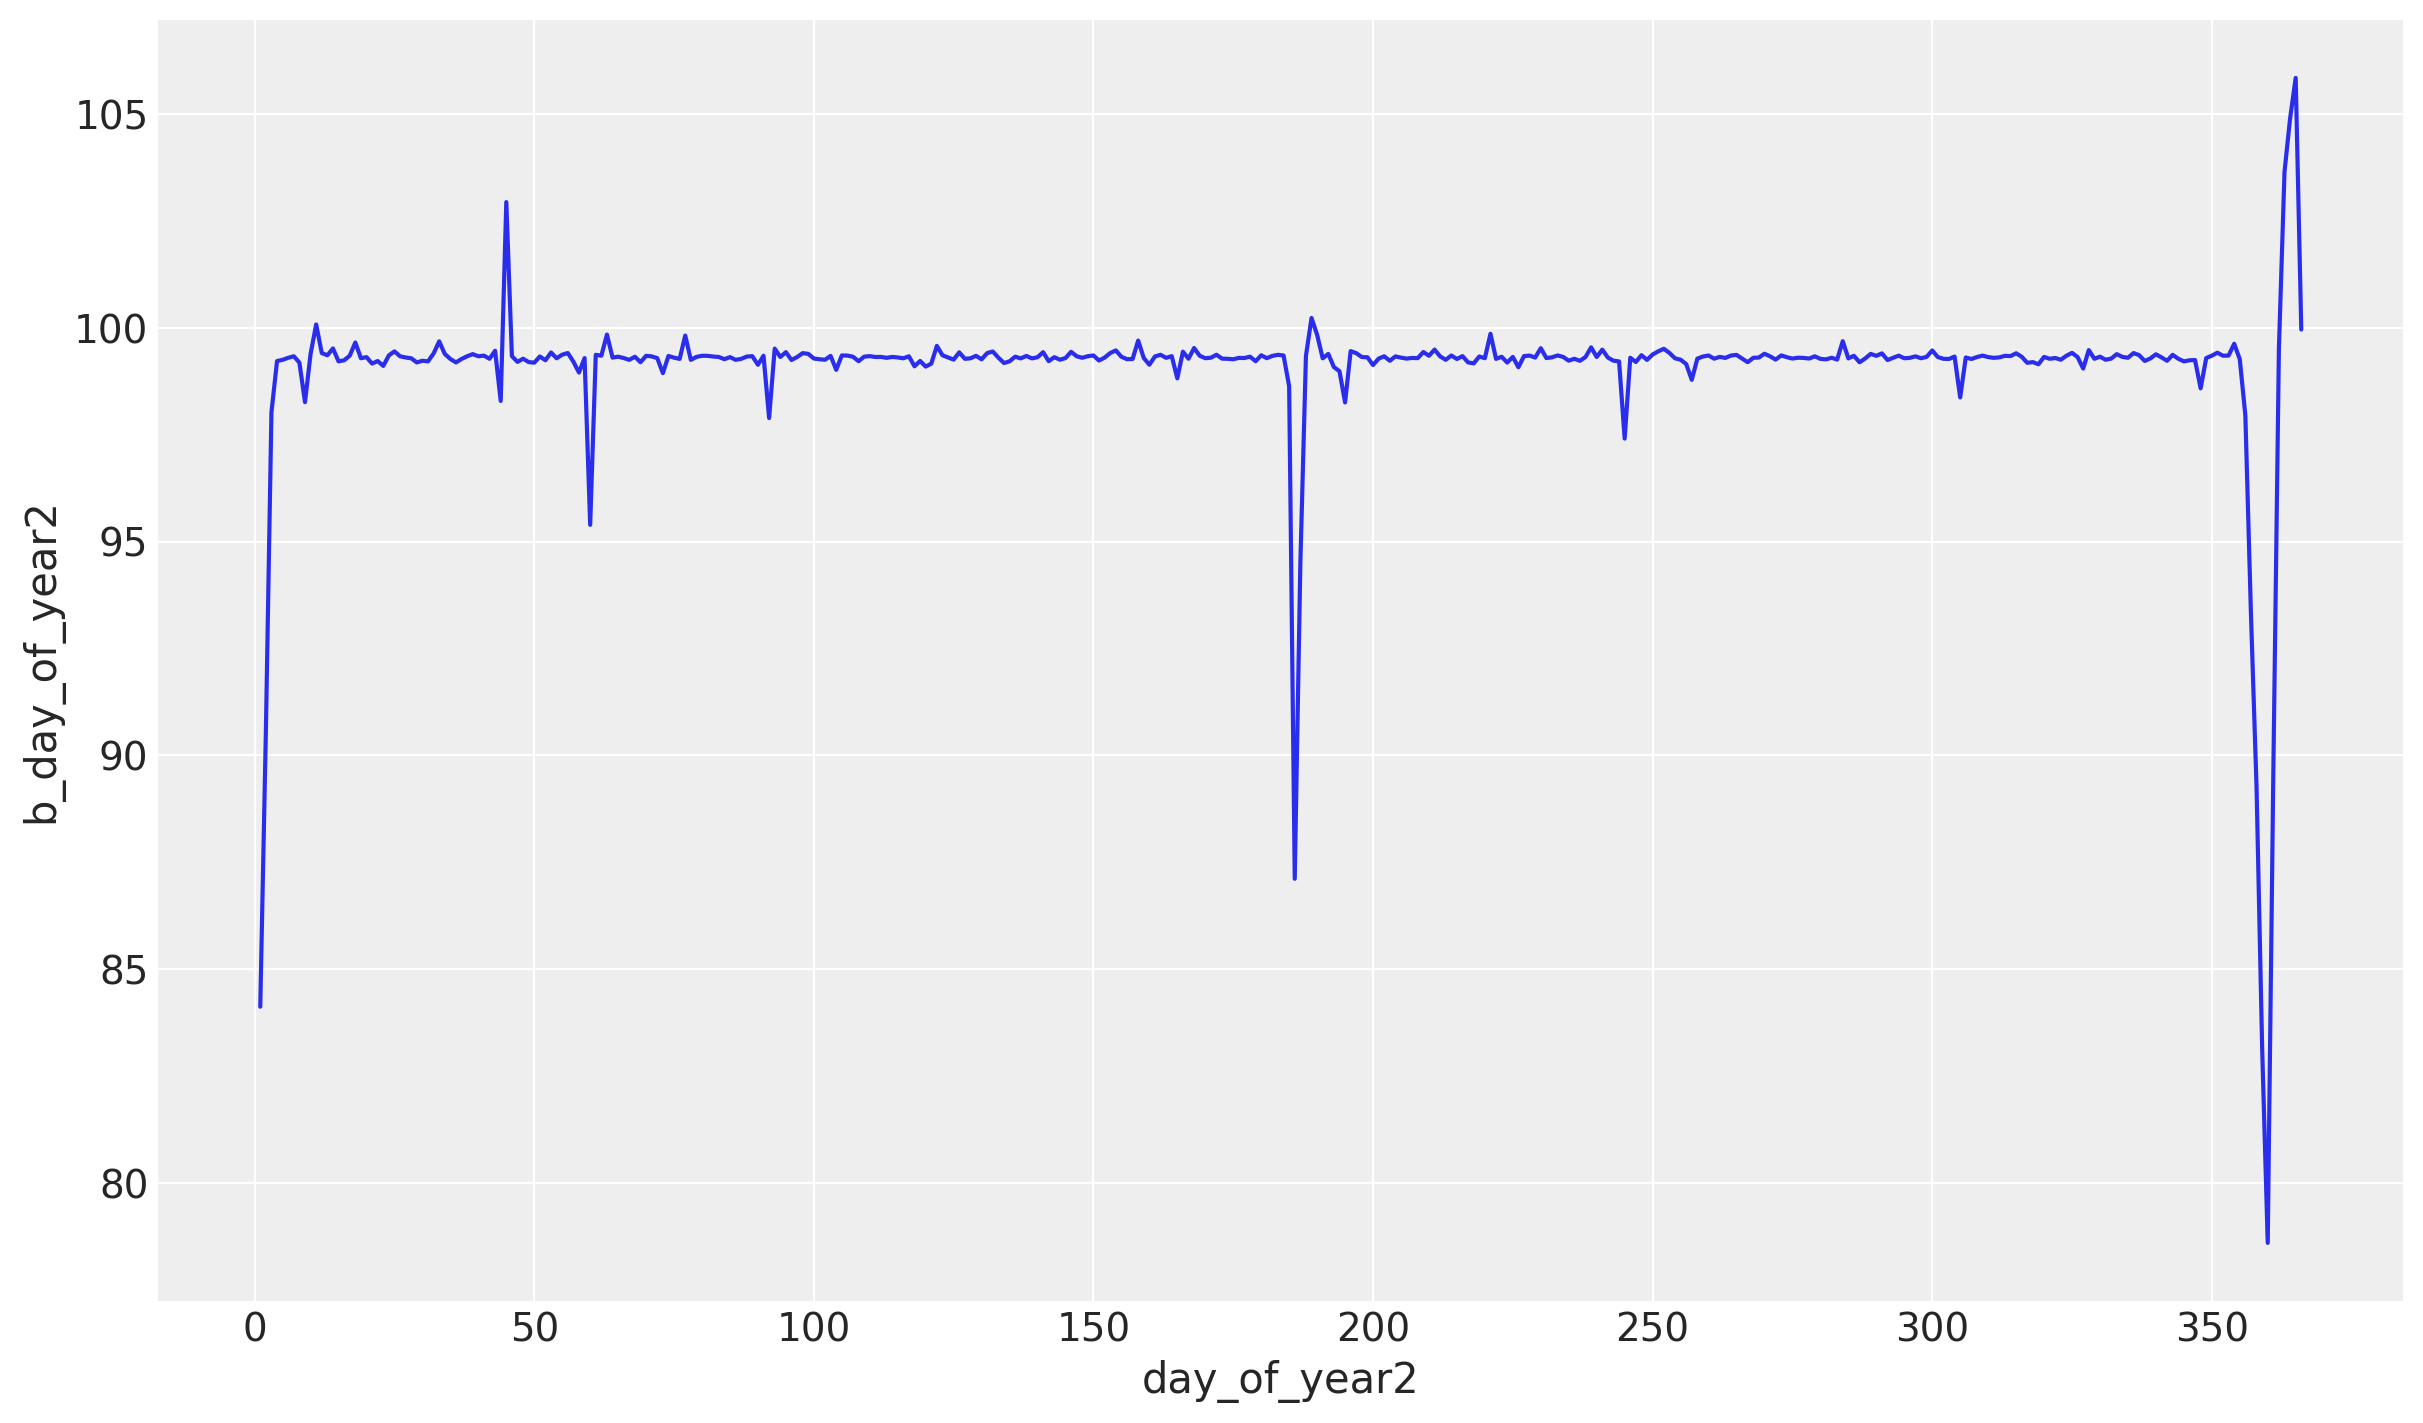

In [25]:
pp_b_day_of_year2_original_scale.mean(dim=("chain", "draw")).plot()

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


Text(0.5, 1.0, 'Posterior Predictive')

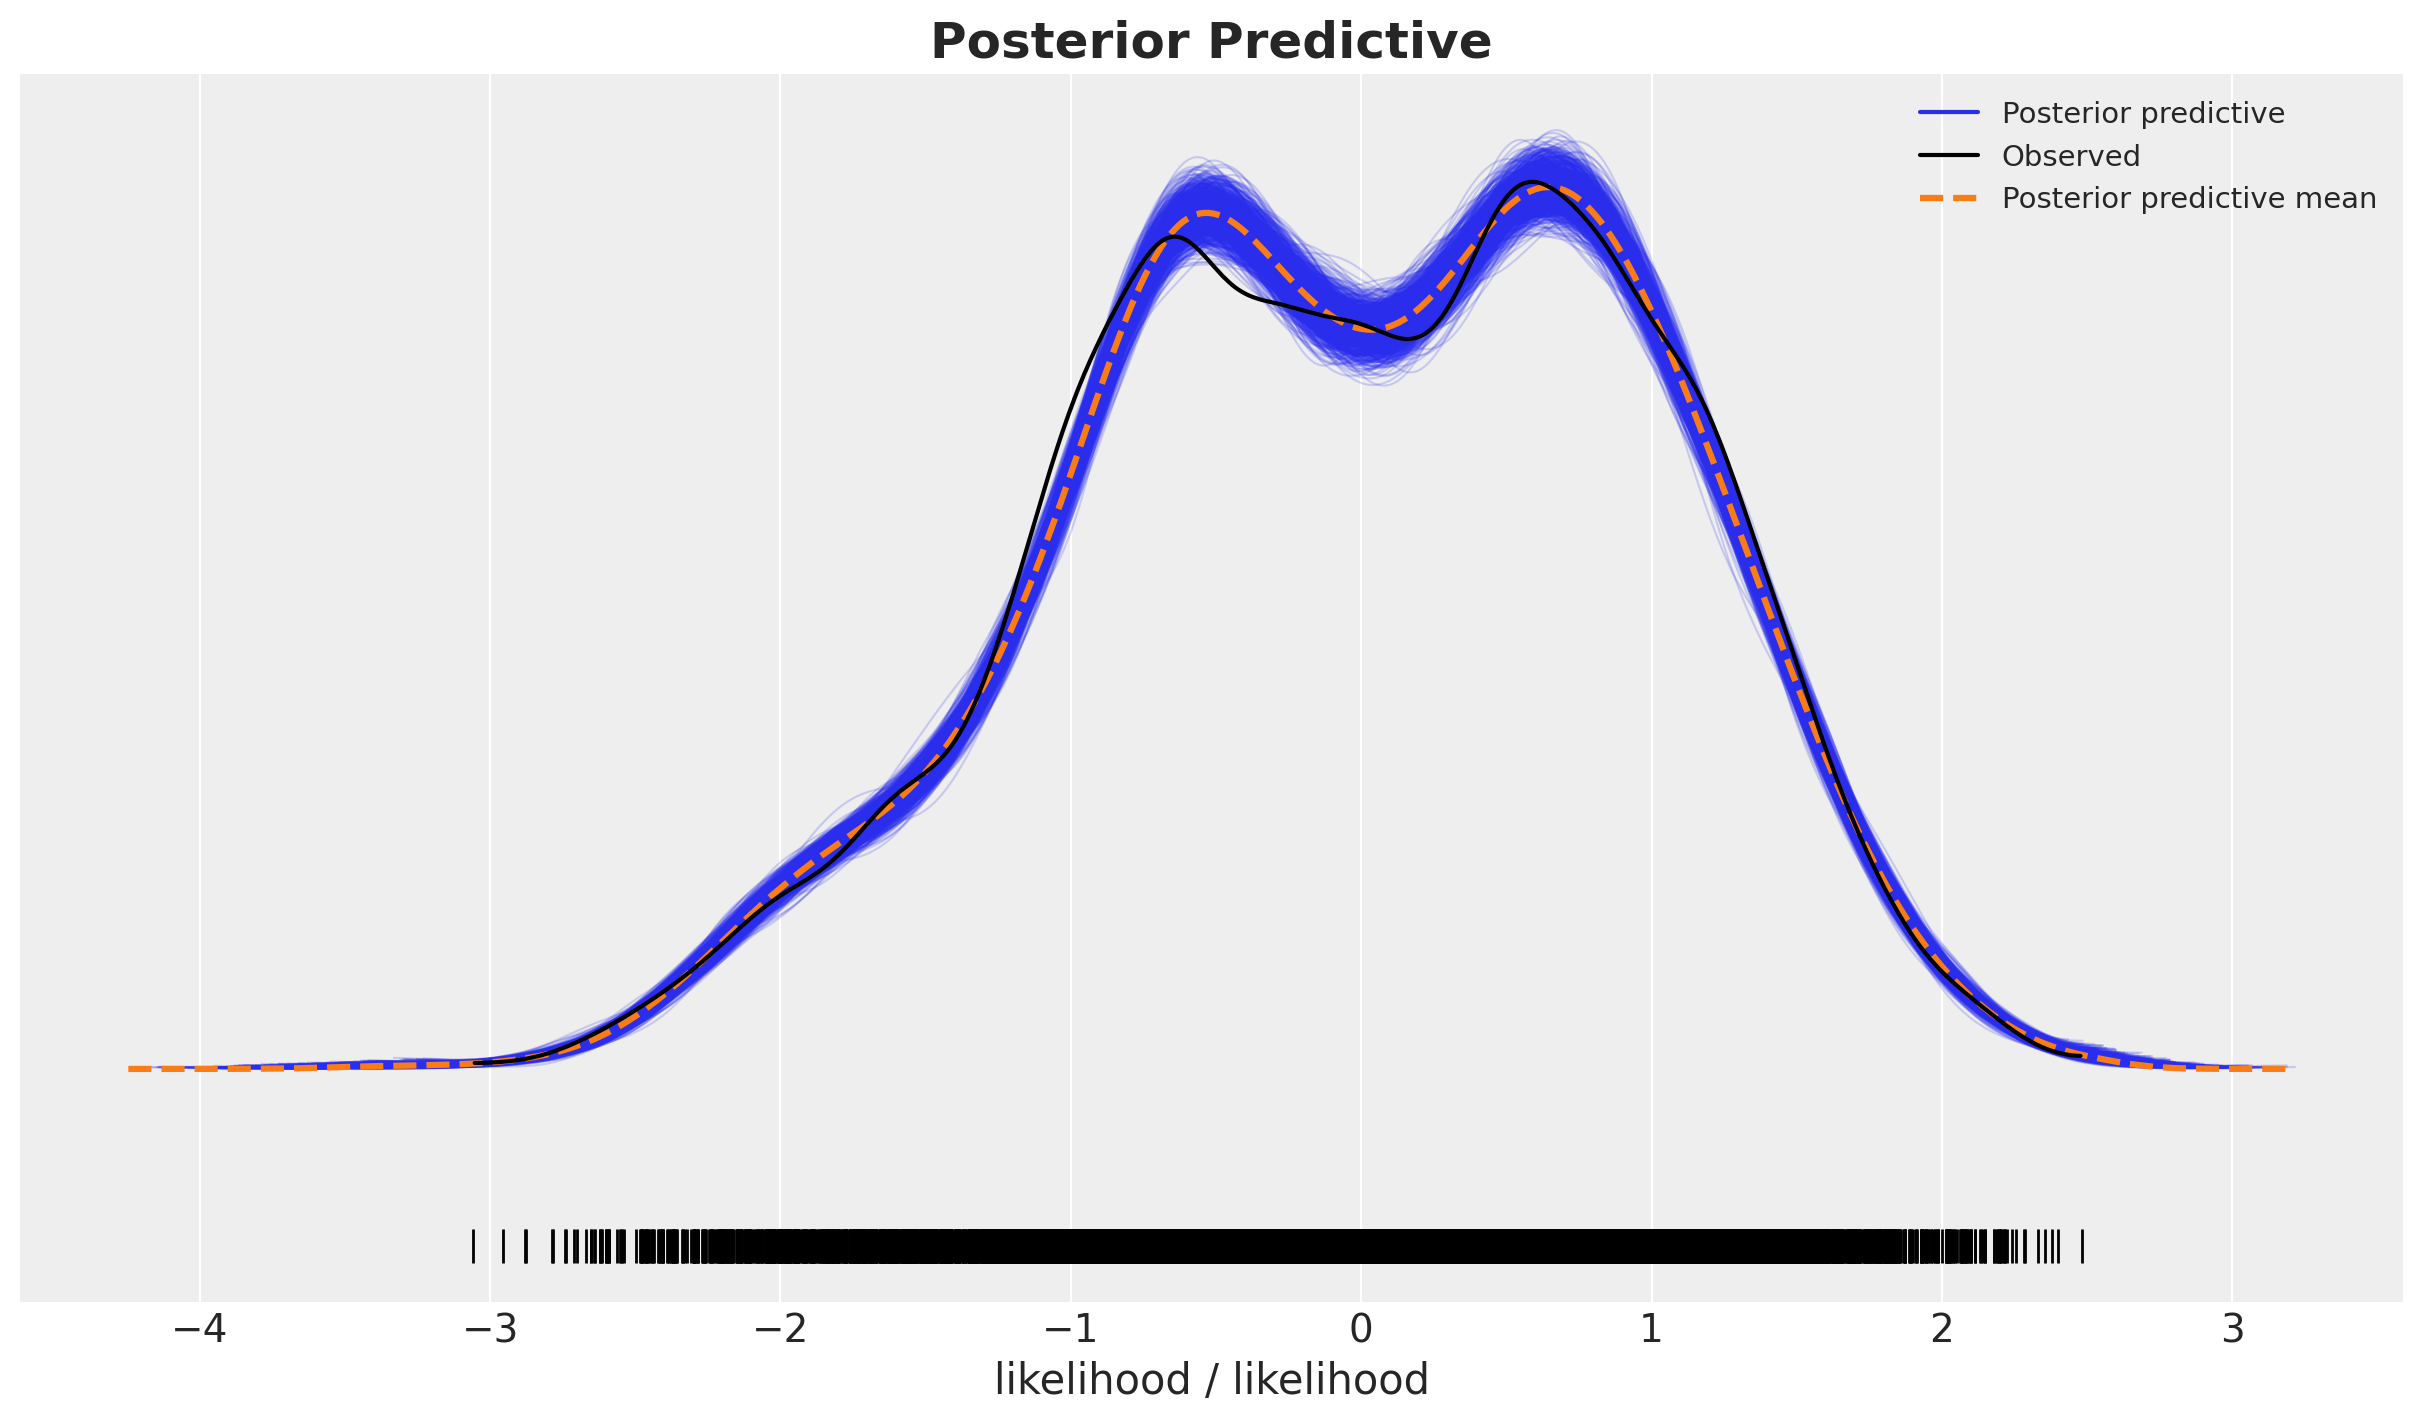

In [26]:
fig, ax = plt.subplots()
az.plot_ppc(
    data=posterior_predictive,
    num_pp_samples=1_000,
    observed_rug=True,
    random_seed=seed,
    ax=ax,
)
ax.set_title(label="Posterior Predictive", fontsize=18, fontweight="bold")